# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

<a class="ancor" id="0-bullet"></a>
## Оглавление

* [Загрузка данных](#1-bullet)
* [Предобработка данных](#2-bullet)
* [Категоризация данных](#3-bullet)
* [Исследование параметров квартир](#4-bullet)
* [Исследование длительности экспозиции квартир](#5-bullet)
* [Исследование полной стоимости квартир](#6-bullet)
* [Исследование стоимости квадратного метра](#7-bullet)
* [Исследование влияние удалённости от центра города](#8-bullet)
* [Выводы](#8-bullet)

In [1]:
import re
import math
from typing import Optional

import pandas as pd
from matplotlib import pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

<a class="ancor" id="1-bullet"></a>

### Загрузка данных

In [3]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except FileNotFoundError:
    df = pd.read_csv('../data/1_3_scientific_data_analysis_real_estate.csv', sep='\t')

Посмотрим несколько случайных записей

In [4]:
df.sample(20, random_state=42)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7944,14,2990000.0,35.0,2019-03-29T00:00:00,1,NaN,17.0,16.0,10,NaN,False,False,9.0,NaN,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7539,8,3790000.0,33.0,2018-12-18T00:00:00,1,2.50,7.0,18.0,2,NaN,False,False,5.6,NaN,Санкт-Петербург,27455.0,8621.0,1.0,217.0,0.0,NaN,90.0
9889,1,12990000.0,191.0,2017-08-31T00:00:00,7,3.30,5.0,136.1,2,NaN,False,False,16.0,0.0,Санкт-Петербург,26856.0,5704.0,0.0,NaN,1.0,1017.0,77.0
649,1,7210000.0,61.5,2018-10-02T00:00:00,3,2.92,5.0,43.2,4,NaN,False,False,5.7,1.0,Санкт-Петербург,25407.0,3982.0,1.0,483.0,0.0,NaN,89.0
13768,10,550000.0,36.0,2017-08-22T00:00:00,1,NaN,2.0,20.0,1,NaN,False,False,8.0,0.0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,92.0
12927,6,5800000.0,52.3,2017-06-12T00:00:00,2,NaN,12.0,30.5,8,NaN,False,False,10.3,0.0,Санкт-Петербург,36811.0,9487.0,1.0,307.0,0.0,NaN,17.0
4449,13,4400000.0,62.0,2017-11-16T00:00:00,2,NaN,12.0,33.0,4,NaN,False,False,14.0,NaN,Санкт-Петербург,31481.0,12074.0,0.0,NaN,0.0,NaN,68.0
16651,11,5550000.0,64.5,2016-09-21T00:00:00,3,NaN,9.0,39.0,7,NaN,False,False,8.0,0.0,Санкт-Петербург,18870.0,13679.0,1.0,492.0,0.0,NaN,362.0
4771,12,9990000.0,117.1,2015-07-09T00:00:00,5,NaN,4.0,NaN,4,NaN,False,False,NaN,NaN,Санкт-Петербург,21465.0,1404.0,1.0,378.0,2.0,103.0,946.0
12731,20,5350000.0,65.2,2018-10-11T00:00:00,3,NaN,9.0,40.0,4,NaN,False,False,8.5,NaN,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,186.0


В целом, данные импортирвоались нормально

Посмотрим общую информацию по всем данным

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Во многих столбцах присутствуют пропуски данных, некоторые типы данные неправильно распознались. Разберёмся с этими проблемами далее.

Построим гистограммы распределения численных данных

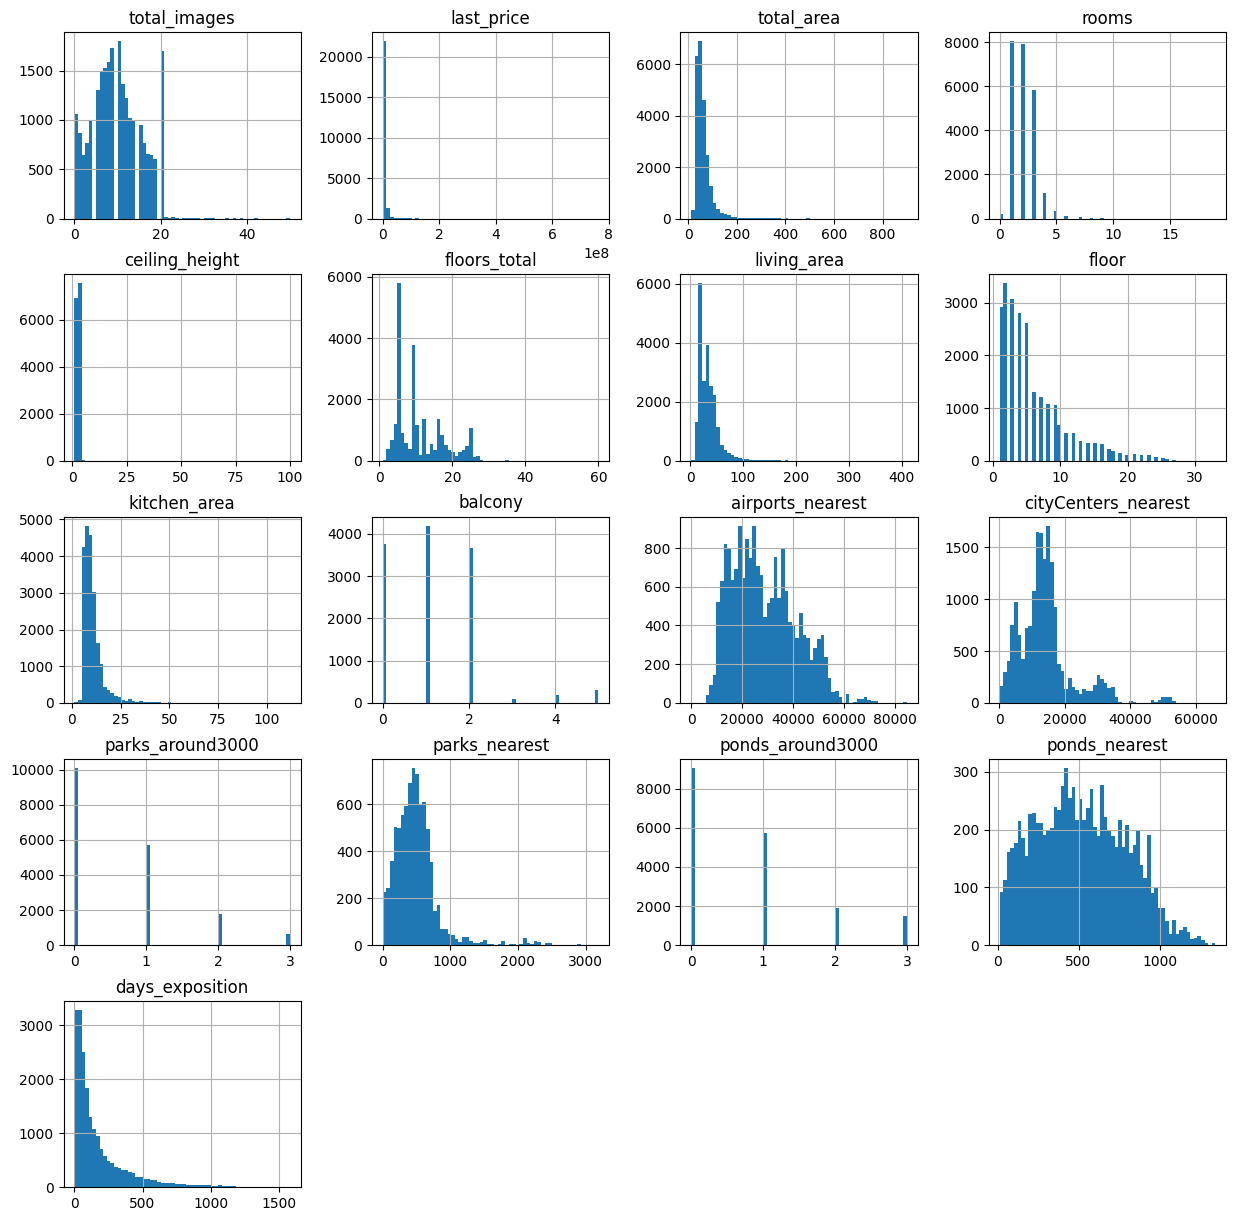

In [6]:
_ = df.drop(
    columns=[
        "first_day_exposition",
        "is_apartment",
        "studio",
        "open_plan",
        "locality_name",
    ]
).hist(
    bins=60,
    figsize=(15, 15),
)

Распределения большинства параметров выглядят разумно, но имеется ряд аномалий.
* Имеется явный выброс в значениях высоты потолков
* В количестве фотографий квартир имеется странный пик на 20 фотографиях
* В данных вероятно присутствует очень небольшое количество очень больших и дорогих квартир, данные по которым слишком мало, но они могут искажать изучаемые статистики

**Вывод**

Данные загрузились успешно.

В данных присутствуют пропуски и аномальные значения, которые необходиом устранить.

[Оглавление](#0-bullet)

<a class="ancor" id="2-bullet"></a>

## Предобработка данных

### Заполнение пропусков

Посмотрим на общее распределение пропусков по категориям

In [7]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Начнём с высоты потолков.

Посмотрим как в целом распределены данные.

In [8]:
df["ceiling_height"].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медианное значение выглядит адекватным, заполним пропуски этим значением.

In [9]:
df.fillna({"ceiling_height": df["ceiling_height"].median()}, inplace=True)

Количество пропусков названии населенного пункта незначительно, просто удалим такие записи

In [10]:
df.dropna(subset=["locality_name"], inplace=True)

Разберёмся с пропусками в общем количестве этажей.

Первое предположение, которое приходит в голову: пропуски в количестве этажей здания может означать, что здание одноэтажное.

Проверим это, посмотрев на данные по этажам квартир для этих объявлений.

In [11]:
df[df["floors_total"].isna()]["floor"].describe()

count    85.000000
mean     10.094118
std       6.211785
min       1.000000
25%       5.000000
50%       8.000000
75%      14.000000
max      24.000000
Name: floor, dtype: float64

Предположение не подтвердилось.

Тогда просто удалим такие объявления из анализа, так как их количество очень незначительно (85)

In [12]:
df.dropna(subset=["floors_total"], inplace=True)

Для объявлений, в которых пропущены жилая площадь и площадь кухни, пропуски, на первый взгляд, хочется заменить медианными значениями этих площадей для объявлений с соответствующим количеством комнат.

Однако, такой подход может привести к различным аномалиям, например к тому, что жилая площадь для некотрых объявлений станет больше общей.

Более надежным способом выглядит рассчитать медиану доли пропущенной площади от общей для объявлений с таким же количеством комнат, а потом для заполнения пропусков домножить общую площадь на соответствующие медианные доли.

In [13]:
# Вычисляем медианные доли жилой площади и площади кухни по отдельности для каждого количества комнат
living_fraction = (
    df.assign(ratio=df["living_area"] / df["total_area"])
    .groupby("rooms")["ratio"]
    .transform("median")
)
kitchen_fraction = (
    df.assign(ratio=df["kitchen_area"] / df["total_area"])
    .groupby("rooms")["ratio"]
    .transform("median")
)

# Заполняем пропуски в living_area и kitchen_area
df.loc[df["living_area"].isna(), "living_area"] = (
    df.loc[df["living_area"].isna(), "total_area"] * living_fraction
)
df.loc[df["kitchen_area"].isna(), "kitchen_area"] = (
    df.loc[df["kitchen_area"].isna(), "total_area"] * kitchen_fraction
)

Проверим всё ли заполнилось

In [14]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area              194
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Не все пропуски площади кухонь заполнились. Посмотирм на них более подробно

In [15]:
df[df["kitchen_area"].isna()].describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,194.000000,1.940000e+02,194.000000,194.0,194.000000,194.000000,194.000000,194.000000,0.0,126.000000,117.000000,117.000000,117.000000,28.000000,117.000000,68.000000,180.000000
mean,7.840206,3.344493e+06,29.321701,0.0,2.842010,16.896907,20.034458,8.536082,NaN,1.579365,24531.658120,13403.743590,0.290598,586.285714,0.820513,524.191176,110.322222
std,5.086835,5.084414e+06,26.051030,0.0,1.762886,6.925936,18.178601,6.311535,NaN,0.661552,12439.138386,5047.408417,0.558011,304.769234,0.877058,276.420470,159.883395
min,0.000000,9.457500e+05,15.500000,0.0,2.500000,3.000000,2.000000,1.000000,NaN,0.000000,6989.000000,1261.000000,0.000000,38.000000,0.000000,72.000000,3.000000
25%,4.000000,2.300000e+06,24.062500,0.0,2.650000,12.000000,16.000000,3.000000,NaN,1.000000,14509.000000,11618.000000,0.000000,392.750000,0.000000,345.250000,27.750000
50%,7.000000,2.700000e+06,26.075000,0.0,2.650000,17.000000,18.000000,7.000000,NaN,2.000000,21460.000000,13615.000000,0.000000,532.000000,1.000000,527.500000,49.500000
75%,11.000000,3.395000e+06,28.375000,0.0,2.700000,23.000000,19.975000,13.000000,NaN,2.000000,34201.000000,16414.000000,0.000000,757.250000,1.000000,683.250000,119.250000
max,21.000000,7.100000e+07,371.000000,0.0,27.000000,35.000000,255.862069,26.000000,NaN,2.000000,55551.000000,29846.000000,2.000000,1199.000000,3.000000,1159.000000,931.000000


Обращает не себя внимание тот факт, что во всех случаях количество комнат равно нулю. Это студии?

In [16]:
df[df["kitchen_area"].isna()]["studio"].value_counts()

studio
True     135
False     59
Name: count, dtype: int64

В большинстве случаев так оно и есть, но не во всех...

А если это студии или квартиры с открытой планировкой?

In [17]:
df[(df["kitchen_area"].isna()) & (df["studio"] | df["open_plan"])].shape[0] / df[
    df["kitchen_area"].isna()
].shape[0]

1.0

Да, так оно и есть.

Для студий и квартир с открытой планировкой площадь кухни роли не играет, поэтому оставим её пустой.

В графе о том является ли квартира апартаментами большое количество пропусков. Большая часть людей вообще не знает, чем апартаменты отличаются от жилой квартиры и не особо задумываются об этом. Поэтому разумно предположить, что если инфомрации о том является ли квартира апартаментами не указана, то это означает, что такая квартира апартаментами не является.

Поэтому заменим все пропуски значениями False

In [18]:
df.fillna({"is_apartment": "False"}, inplace=True)

Если информация о балконе не указана, то это скорее всего означает, что его нет.

In [19]:
df.fillna({"balcony": 0}, inplace=True)

Для заполнения пропусков информации о расстоянии до центра, аэропорта, количестве парков и прудов разумнее всего попытаться использовать медианные значения этих параметров для соответствующих населённых пунктов.

Это требует предварительной работы с колонкой `locality_name`, нужно удалить из неё все неявные дубликаты.

Для начала проверим какие типы неявных дубликатов у нас встречаются.

Будем считать, что самыми распространёнными ошибками в написании являются замены 1 или 2 букв (лично я при написании часто переставляю соседние буквы местами и "прицепляю" последнюю букву одного слова к начал уследующего).

Для поиска таких ошибок найдём в списке населённых пунктов все слова, для которых [Расстояние Хэмминга](https://ru.wikipedia.org/wiki/Расстояние_Хэмминга) не превышает 2. Это даст нам некоторое количество ложноположительных результатов, но функцию для вычисления расстояния Хэмминга легко написать, а результат можно проверить самостоятельно (в общем случае подход не очень хороший, мы не отслеживаем пропуски букв и возможные вариации в написании типов населённых пунктов (пгт/посёлок городского типа), но попробуем такой подход).

In [20]:
def find_hamming(target, words, max_distance):
    """Функция для поиска похожих слов по расстоянию Хэмминга"""

    def hamming_distance(word1, word2):
        """Вычисляет расстояние Хэмминга между двумя словами"""
        if len(word1) != len(word2):
            return float("inf")  # возвращаем бесконечность для слов разной длины
        return sum(c1 != c2 for c1, c2 in zip(word1, word2))

    similar = [word for word in words if hamming_distance(target, word) <= max_distance]
    if len(similar):
        similar.append(target)
        print(similar)

In [21]:
towns = list(df["locality_name"].unique())
for i in range(len(towns)):
    find_hamming(towns.pop(), towns, 2)

['деревня Рапполово', 'деревня Лупполово']
['посёлок Пансионат Зелёный Бор', 'поселок Пансионат Зелёный Бор']
['поселок Старая Малукса', 'посёлок Старая Малукса']
['посёлок городского типа Токсово', 'поселок городского типа Токсово']
['поселок Мурино', 'посёлок Сумино', 'поселок Сумино']
['поселок Перово', 'посёлок Перово']
['посёлок Коробицыно', 'поселок Коробицыно']
['поселок городского типа Форносово', 'посёлок городского типа Форносово']
['посёлок Усть-Луга', 'поселок Усть-Луга']
['посёлок Кобралово', 'поселок Кобралово']
['поселок Лисий Нос', 'посёлок Лисий Нос']
['поселок Жилгородок', 'посёлок Жилгородок']
['поселок городского типа Рябово', 'посёлок городского типа Рябово']
['поселок Мельниково', 'посёлок Мельниково']
['деревня Тарасово', 'деревня Торосово']
['посёлок Мичуринское', 'поселок Мичуринское']
['посёлок Петровское', 'поселок Петровское']
['посёлок Сапёрный', 'посёлок Сапёрное']
['поселок Стеклянный', 'посёлок Стеклянный']
['посёлок Возрождение', 'поселок Возрождение']


Похоже, что самой рапространённой ошибкой является замена е на ё в слове "Посёлок".

Исправим её, и попробуем поискать неявные дубликаты еще раз.

In [22]:
df["locality_name"] = df["locality_name"].str.replace("ё", "е", flags=re.IGNORECASE)
towns = list(df["locality_name"].unique())
for i in range(len(towns)):
    find_hamming(towns.pop(), towns, 2)

['деревня Рапполово', 'деревня Лупполово']
['поселок Парголово', 'поселок Гарболово']
['деревня Тарасово', 'деревня Торосово']
['поселок Саперный', 'поселок Саперное']
['поселок Мурино', 'поселок Сумино']
['деревня Кальтино', 'деревня Калитино']
['поселок городского типа Сиверский', 'поселок городского типа Советский']


Похоже, что неявных дубликатов не осталось.

Проверим заодно на явные дубликаты.

In [23]:
df.duplicated().sum()

np.int64(0)

Явных дубликатов в данных нет.

Вернёмся к заполнению пропусков. Вспомним, что за пропуски у нас остались.


In [24]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Поработаем с пропуском в расстоянии до аэропорта.

Исходная гипотеза состоит в том, что можно попытаться заполнить пропуски в расстоянии до аэропорта медианным значением расстояния из конкретного населённого пункта до аэропорта.

Составим сводную таблицу, в которой посчитаем для каждого населённого пункта количество объявлений, в которых указано расстояние до аэропорта и количество объявлений, в которых это расстояние не указано.

Затем выведем строчки для которых есть ненулевые значения в обоих столбцах.

In [25]:
def towns_stats(df: pd.DataFrame, stat: str) -> pd.DataFrame:
    """Функция для получения статистики по городам"""
    stats = df.pivot_table(
        index="locality_name", values=stat, aggfunc=["count", lambda x: x.isna().sum()]
    )
    stats.columns = ["count", "missing"]
    return stats.query("missing > 0 and count > 0")

In [26]:
towns_stats(df, "airports_nearest")

,count,missing
locality_name,,
Колпино,337,1
Красное Село,174,2
Кронштадт,95,1
Ломоносов,132,1
Санкт-Петербург,15567,84
поселок Шушары,436,3


Санкт-Петербург - довольно большой город и для него неразумно заполнять пропуски медианным расстоянием, это будет некорректно.

Остальных объявлений довольно мало, но заполним хотябы их.

In [27]:
def correct_town_stats(
    df: pd.DataFrame, stat: str, exclude: Optional[list[str]] = None
) -> None:
    """Функция для исправления статистики по городам."""
    for town in towns_stats(df, stat).index:
        if not exclude or town not in exclude:
            df.loc[
                (df["locality_name"] == town) & (df[stat].isna()),
                stat,
            ] = df.loc[df["locality_name"] == town, stat].median()

In [28]:
correct_town_stats(df, "airports_nearest", ["Санкт-Петербург"])

Проведём аналогичную процедуру для колонок:
* cityCenters_nearest
* parks_around3000
* ponds_around3000

Причём для последних 2 колонках не имеет смысл Исключать Санкт-Петербург

In [29]:
correct_town_stats(df, "cityCenters_nearest", ["Санкт-Петербург"])
for col in ["parks_around3000", "ponds_around3000"]:
    correct_town_stats(df, col)

Посмотрим сколько пропусков в этих четырёх колонках осталось.

In [30]:
df[
    ["airports_nearest", "cityCenters_nearest", "parks_around3000", "ponds_around3000"]
].isna().sum()

airports_nearest       5516
cityCenters_nearest    5492
parks_around3000       5432
ponds_around3000       5432
dtype: int64

Осталось довольно много, но заполнить их чем-то осмысленным выглядит проблематичным, оставим как есть...

Разберёмся с расстоянием до ближайшего парка.

* Во-первых, заметим, что все значения этих расстояний в исходных данных не превышают 3 км.
* Во-вторых, если количество парков в радиусе 3 км 0, то значит и расстояние до парка - параметр нерелевантный.

Посмотрим на количество объявлений в которых расстояние до ближайшего парка пропущено, при этом количество парков в радиусе 3 км ненулевое.

In [31]:
df.query("parks_nearest.isna() and parks_around3000 > 0")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8650,5,3790000.0,34.0,2019-04-15T00:00:00,1,2.5,5.0,17.3,2,False,False,False,7.0,0.0,Кронштадт,67850.0,49575.0,2.0,NaN,2.0,NaN,15.0


Не густо...

Получается, что пропуски данных в этом столбце означают, что в радиусе 3 км парков нет и этот параметр нерелевантен.

Проверим тоже самое для прудов в радиусе 3 км.

In [32]:
df.query("ponds_nearest.isna() and ponds_around3000 > 0")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
81,9,10949000.0,68.00,2018-12-27T00:00:00,1,2.65,10.0,32.819362,6,False,False,False,16.848980,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
593,20,4200000.0,38.30,2019-04-16T00:00:00,1,2.60,16.0,19.800000,10,False,False,False,10.100000,2.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
604,11,9899000.0,101.00,2018-12-12T00:00:00,3,3.00,5.0,62.000000,3,False,False,False,15.000000,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
742,7,37000000.0,161.00,2016-05-22T00:00:00,3,2.65,9.0,84.000000,8,False,False,False,20.687892,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,402.0
795,19,7100000.0,59.60,2019-02-13T00:00:00,2,3.40,5.0,36.600000,2,False,False,False,12.500000,0.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21668,9,4500000.0,34.30,2019-03-04T00:00:00,1,2.65,9.0,17.500000,3,False,False,False,8.900000,1.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
21881,15,44500000.0,169.00,2019-02-28T00:00:00,3,3.30,9.0,101.000000,7,False,False,False,18.000000,4.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN
21955,19,130000000.0,431.00,2017-10-02T00:00:00,7,3.70,8.0,220.000000,5,False,False,False,20.000000,5.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,161.0
22554,5,3415000.0,31.65,2019-04-16T00:00:00,1,2.65,24.0,15.275483,14,False,False,False,8.700000,2.0,Санкт-Петербург,NaN,NaN,0.0,NaN,1.0,NaN,NaN


Здесь уже кое-что есть.

Заполним такие пробелы мадианным расстоянием до пруда для соответствующих населённых пунктов.

In [33]:
med_ponds_dist = (
    df.query("ponds_nearest.isna() and ponds_around3000 > 0")
    .groupby("locality_name")["ponds_nearest"]
    .transform("median")
)
df.loc[(df["ponds_nearest"].isna()) & (df["ponds_around3000"] > 0), "ponds_nearest"] = (
    med_ponds_dist
)

Еще раз посмотрим на текущее количество пропусков.

In [34]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              194
balcony                     0
locality_name               0
airports_nearest         5516
cityCenters_nearest      5492
parks_around3000         5432
parks_nearest           15535
ponds_around3000         5432
ponds_nearest           14529
days_exposition          3171
dtype: int64

Осталось посмотреть на объявления в пропусками в днях экспозиции объявлений.

Посмотрим как для объявлений, в которых указана и не указана длительность экспозиции распределены цена при продаже и общая площадь.

In [35]:
def compare_hists(
    dfs: list[pd.DataFrame],
    data_col: str,
    titles: list[str],
    bins: int = 60,
    bin_range: Optional[tuple] = None,
    xlabel: str = "",
    title: str = "",
) -> None:
    """Строит несколько гистограмм на одном графике."""
    ax = dfs[0].hist(
        column=data_col,
        bins=bins,
        range=bin_range,
        alpha=0.25,
        label=titles[0],
        density=True,
        figsize=(10, 5),
    )
    for i in range(1, len(dfs)):
        dfs[i].hist(
            column=data_col,
            bins=bins,
            range=bin_range,
            alpha=0.25,
            label=titles[i],
            density=True,
            ax=ax,
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.legend()

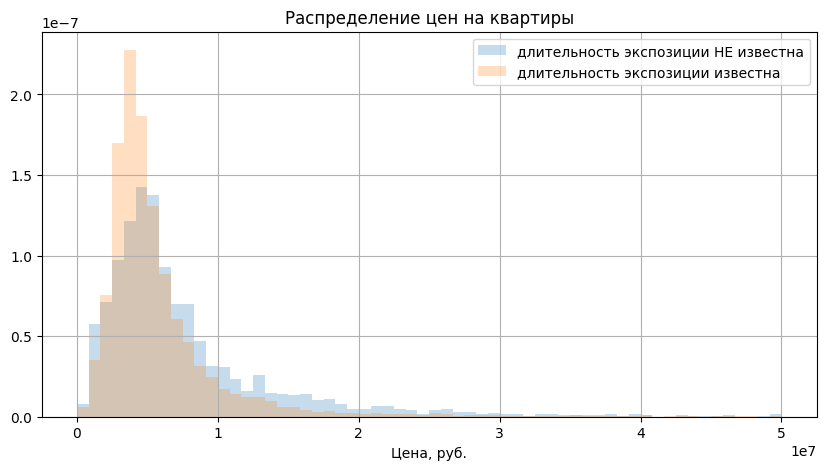

In [36]:
compare_hists(
    dfs=[
        df[df["days_exposition"].isna()],
        df[~df["days_exposition"].isna()],
    ],
    data_col="last_price",
    titles=[
        "длительность экспозиции НЕ известна",
        "длительность экспозиции известна",
    ],
    bin_range=(0, 5e7),
    xlabel="Цена, руб.",
    title="Распределение цен на квартиры",
)

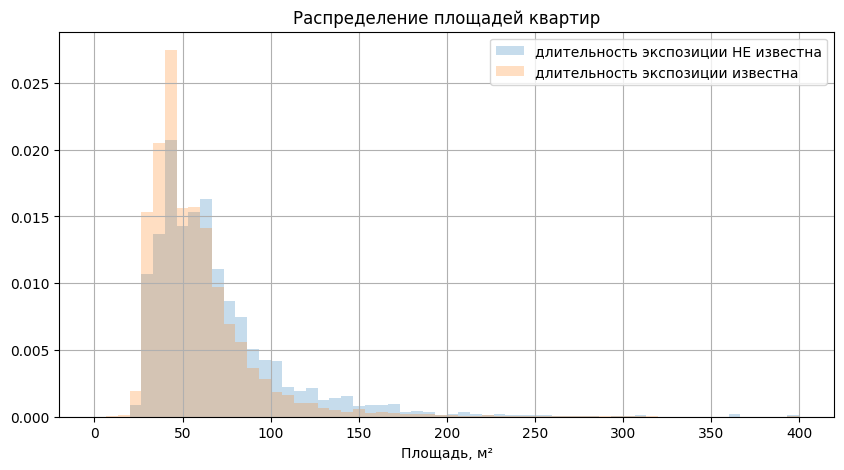

In [37]:
compare_hists(
    dfs=[
        df[df["days_exposition"].isna()],
        df[~df["days_exposition"].isna()],
    ],
    data_col="total_area",
    titles=[
        "длительность экспозиции НЕ известна",
        "длительность экспозиции известна",
    ],
    xlabel="Площадь, м²",
    title="Распределение площадей квартир",
    bin_range=(0, 400),
)

В целом данные распделены очень похоже. Скорее всего, отсутствие данных в этом столбце означает, что квартира просто еще не продана. Давайте посмотрим на распределние объявлений по годам публикации, заодно немного "причешем" столбец с данными о дате публикации и добавим пару дополнительных столбцов на его сонове (день недели, месяц и год публикации).

In [38]:
df["first_day_exposition"] = pd.to_datetime(
    df["first_day_exposition"], format="%Y-%m-%dT%H:%M:%S"
)
df["pub_year"] = df["first_day_exposition"].dt.year
df["pub_weekday"] = df["first_day_exposition"].dt.day_name()
df["pub_weekday"] = pd.Categorical(
    df["pub_weekday"],
    categories=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    ordered=True,
)
df["pub_month"] = df["first_day_exposition"].dt.month_name()
df["pub_month"] = pd.Categorical(
    df["pub_month"],
    categories=[
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ],
    ordered=True,
)

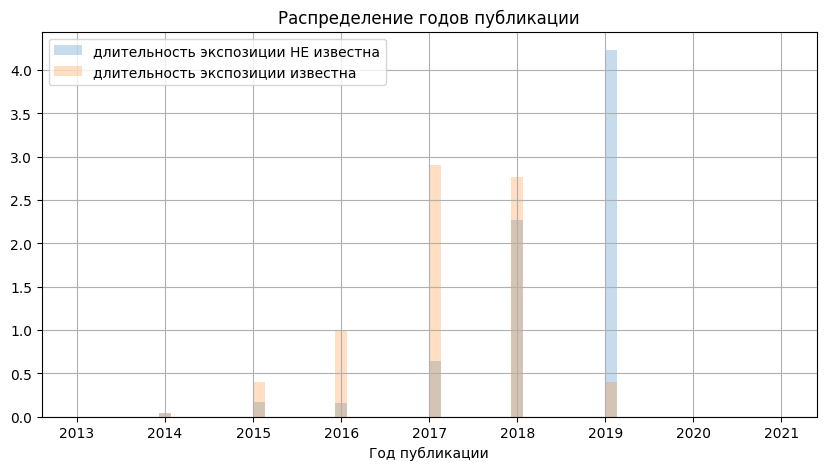

In [39]:
compare_hists(
    dfs=[
        df[df["days_exposition"].isna()],
        df[~df["days_exposition"].isna()],
    ],
    data_col="pub_year",
    titles=[
        "длительность экспозиции НЕ известна",
        "длительность экспозиции известна",
    ],
    xlabel="Год публикации",
    title="Распределение годов публикации",
    bin_range=(2013, 2021),
)

Предположение подтверждается, действительно, объявления, в которых нет данных о длительности экспозиции являются, по большей части, свежими.

Можно было бы просто удалить такие объявления, но оставим их, чтобы было побольше данных о свойствах продаваемых квартир.

Остались пропуски, разумно заполнить которые не представляется возможным.

Скорее всего это связано с тем, что пропущенные данные просто не релевантны для соответствующих объявлений.

### Изменение типов данных

Посмотрим как распознались типы данных

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23371 non-null  float64       
 13  balcony              

Поправим неверные типы.
1. Является ли квартира апартаментами - булев тип

In [41]:
# Стандартный astype(bool) не сработает
df["is_apartment"] = df["is_apartment"] == True

Скоррективруем численные типы:
1. общее количество этажей - int
2. Количество балконов - int
3. Количество парков и прудов в диапазоне 3000 метров - int
4. Количество дней экспозиции - timedelta

In [42]:
# Без этого костыля пандас отказывается конверитрвоать дни экспозиции даже в Int64...
df["days_exposition"] = df["days_exposition"].apply(
    lambda x: int(x) if pd.notna(x) else pd.NA
)

df = df.astype(
    {
        "floors_total": "int",
        "balcony": "int",
        "ponds_around3000": "Int64",  # используем Int64, чтобы сохранить NaN
        "parks_around3000": "Int64",  # используем Int64, чтобы сохранить NaN
        "days_exposition": "Int64",  # используем Int64, чтобы сохранить NaN
    }
)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23371 non-null  float64       
 13  balcony              

Интересно посмотреть а сколько у нас всего данных по апартаментам, студиям и квартирам с открытой планировкой

In [44]:
df[["is_apartment", "studio", "open_plan"]].value_counts()

is_apartment  studio  open_plan
False         False   False        23302
              True    False          146
              False   True            67
True          False   False           50
Name: count, dtype: int64

Количество данных здесь совершенно несущественно, их можно отбросить.

In [45]:
df.drop(columns=["is_apartment", "studio", "open_plan"], inplace=True)

Посмотрим еще раз на данные

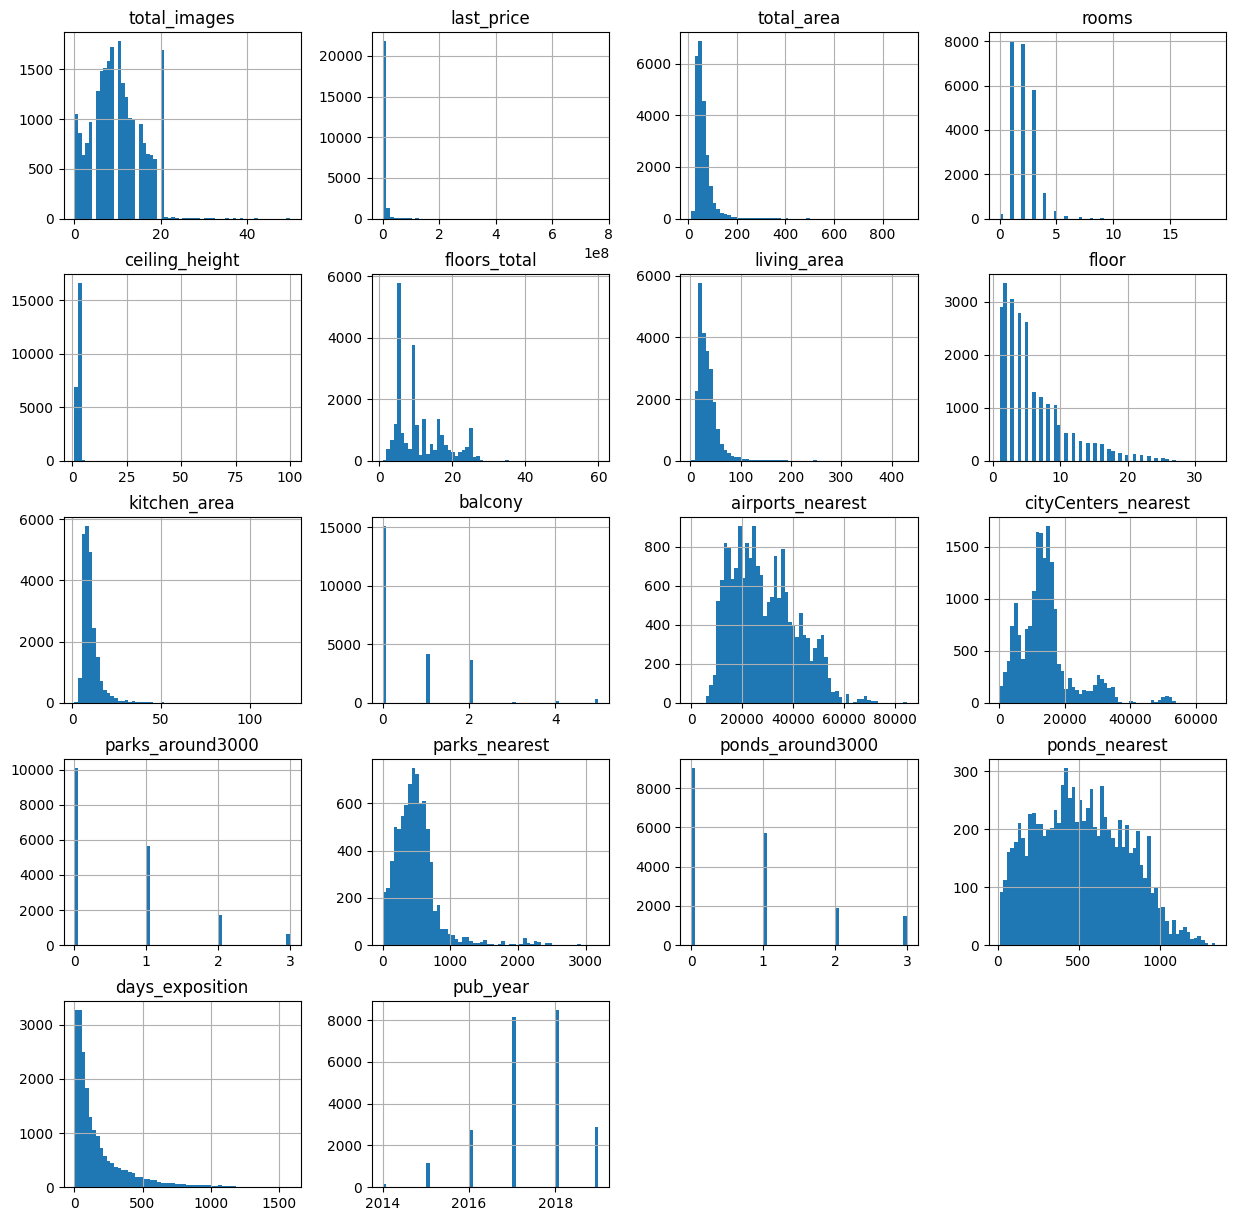

In [46]:
# Используем присваивание, чтобы избежать отображение ненужной информации
_ = df.drop(columns=["first_day_exposition", "locality_name"]).hist(
    bins=60,
    figsize=(15, 15),
)

Избавимся от объявлений с явно аномальными записями, оставив объявления по следующим кртериям:
1. 20 или меньше фотографий
2. Цена продажи менее 3е7
3. Общая площадь менее 200 кв местров
4. Количество комнат менее 6
5. Жилая площадь менее 100 кв метров
6. Общее количество этажей менее 30
7. Площаь кухни менее 40 кв метров
8. Высота потолков менее 2 и не более 4 метров
9. Расстояние до аэропорта менее 62 000 метров
10. Расстояние до центра города менее 54 000 метров
11. Время экспозиции менее 1100 дней

In [47]:
new_df = df.query(
    "total_images < 21 "
    + "and last_price < 3e7 "
    + "and total_area < 300 "
    + "and rooms < 6 "
    + "and 2 < ceiling_height < 4 "
    + "and living_area < 200 "
    + "and floors_total < 30 "
    + "and (kitchen_area < 40 or kitchen_area.isna()) "
    + "and (airports_nearest < 62000 or airports_nearest.isna()) "
    + "and (cityCenters_nearest < 54001 or cityCenters_nearest.isna()) "
    + "and (days_exposition < 1100 or days_exposition.isna())"
)
f"Относительное изменение: {round((df.shape[0] - new_df.shape[0]) / df.shape[0] * 100, 2)}%"

'Относительное изменение: 4.36%'

Применение такого фильтра уменьшило количество объявлений в базе на 4%, что будем считать приемлимым.

Применим изменения и в последний раз посмотрим на получившиеся распределения.

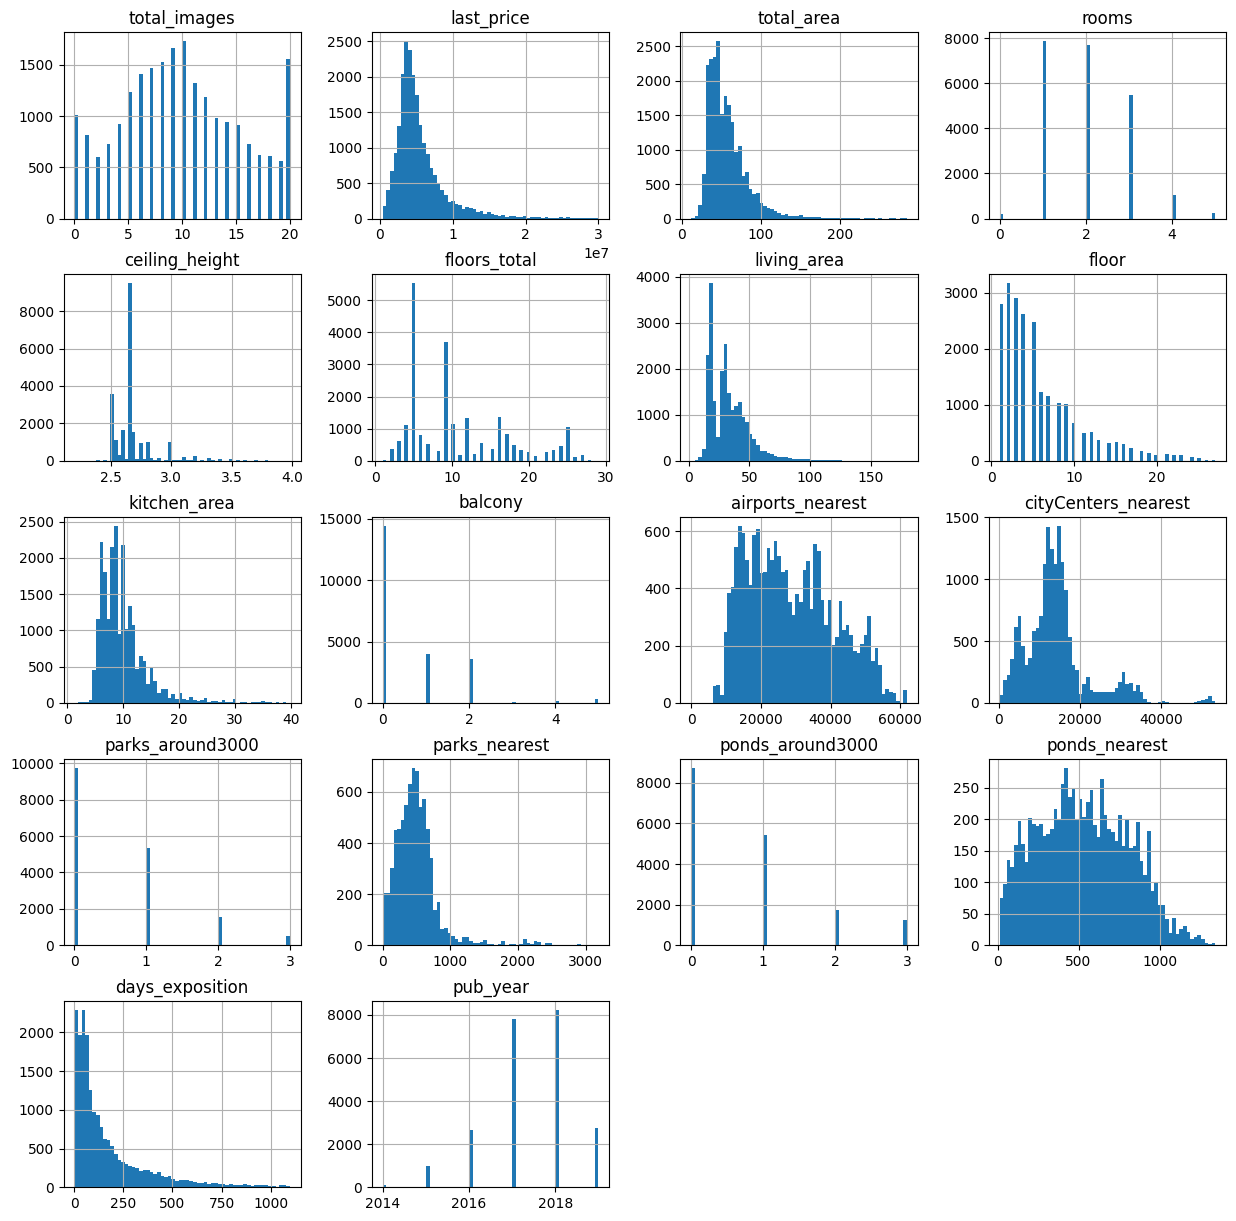

In [48]:
df = new_df.copy()
_ = df.drop(columns=["first_day_exposition", "locality_name"]).hist(
    bins=60,
    figsize=(15, 15),
)

**Вывод**

Предобработка данных выявила несколько проблем в данных:
* Множественные пропуски в данных
    * Пропуски в категиории "высота потолков" были заполнены медианным значением по всему датасету.
    * Объявления с пропусками в названии населённого пункта и общем количестве этажей были удалены, так как предложить разумные значения для заполнения проблематично, а общее количество объявлений с такими пропускам незначительно (134). Отметим, что было сделано предположение, что пропуск в общем количестве этажей означает, что здание одноэтажное, но он не подвердилось.
    * Пропуски в жилой площади и площади кухни были заменены значениями, вычисленными как произведение общей площади на медианное отношение пропущенной площади к общей площади для квартир с таким же количеством комнат.
    * Пропуски в графе апартаменты трактовались как принадлежность квартиры к жилому помещению (False).
    * Пропуски в графе количества балконов трактовались как отсутствие балкона.
    * Пропуски в данных, полученных автоматически (расстояние до аэропорта, центра города, ближайших парков и прудов, а также их количестве в радиусе 3 км) в большинстве своём остались. Незначительная часть пропусков была заполнена медианными значениями для соответствующих населённых пунктов.

* Неявные дубликаты в данных

    Исправлены неявные дубликаты в названиях населённых пунктов ('ё' заменены на 'е').

* Удаление нерепрезентативных данных
    * Удалены данные о том является ли квартира апартаментами, студией или квартирой с открытой планировкой, так как положительных значений там слишком мало.

* Корректировка типов данных
    * Установлен корректный тип данных (Datetime) для даты публикации объявления.
    * Этажность здания, количество балконов, парков и прудов в радиусе 3 км, а также количество дней экспозиции установлены как целочисленные значения.

* Аномальные и нерелевантные значения в данных
  
    Исходя из визуального анализа гистограм распределения численных параметров, оставлены объявления, удовлетворяющие следующим параметрам:
  1. 20 или меньше фотографий
  2. Цена продажи менее 30 000 000
  3. Общая площадь менее 200 кв местров
  4. Количество комнат менее 6
  5. Жилая площадь менее 100 кв метров
  6. Общее количество этажей менее 30
  7. Площаь кухни менее 40 кв метров
  8. Высота потолков более 2 и менее 4 метров
  9. Расстояние до аэропорта менее 62 000 метров
  10. Расстояние до центра города менее 54 000 метров
  11. Время экспозиции менее 1100 дней

[Оглавление](#0-bullet)

<a class="ancor" id="3-bullet"></a>

### Категоризация данных

Добавим категории этажа: первый, последний, другой

In [49]:
def floor_category(row: pd.Series) -> str:
    """Функция для определения категории этажа"""
    if row["floor"] == 1:
        return "первый"
    elif row["floor"] == row["floors_total"]:
        return "последний"
    else:
        return "другой"

In [50]:
df["floor_cat"] = df.apply(floor_category, axis=1)
df[["floor", "floors_total", "floor_cat"]].sample(10, random_state=42)

,floor,floors_total,floor_cat
21945,5,10,другой
261,7,17,другой
17859,1,9,первый
16295,8,8,последний
15517,5,5,последний
16186,4,5,другой
8623,3,9,другой
16682,2,9,другой
11612,2,18,другой
7329,12,12,последний


Добавим колонки с расстоянием до центра города и аэропорта в км

In [51]:
df["cityCenters_dist_km"] = (df["cityCenters_nearest"] / 1000).round(0).astype("Int64")
df["airports_dist_km"] = (df["airports_nearest"] / 1000).round(0).astype("Int64")
df[
    [
        "cityCenters_nearest",
        "cityCenters_dist_km",
        "airports_nearest",
        "airports_dist_km",
    ]
].sample(10, random_state=42)

,cityCenters_nearest,cityCenters_dist_km,airports_nearest,airports_dist_km
21945,14697.0,15,50747.0,51
261,NaN,<NA>,NaN,<NA>
17859,12525.0,13,22903.0,23
16295,NaN,<NA>,NaN,<NA>
15517,5222.0,5,31898.0,32
16186,30318.0,30,24532.0,25
8623,12175.0,12,13643.0,14
16682,10434.0,10,11964.0,12
11612,NaN,<NA>,NaN,<NA>
7329,15968.0,16,49998.0,50


Добавим цену за кв метр и категории этой цены, создав 5 категорий:
* А - 20 % самых дорогих
* B - следующие 20 %
* C - ...
* D - ...
* E - 20 % самых дешевых

Важно, что разбивка на категории здесь привязана к количеству объявлений, а не к абсолютным значениям цен.

Я не хочу использовать здесь разбивку на квартили, чтобы иметь возможность легко выбирать "средний диапазон" цен.

In [52]:
df["price_per_m2"] = (df["last_price"] / df["total_area"]).round(0)
df["price_per_m2_cat"] = pd.qcut(
    df["price_per_m2"], q=5, labels=["E", "D", "C", "B", "A"]
)
df[["last_price", "total_area", "price_per_m2", "price_per_m2_cat"]].sample(
    10, random_state=42
)

,last_price,total_area,price_per_m2,price_per_m2_cat
21945,9990000.0,91.00,109780.0,B
261,4600000.0,83.69,54965.0,E
17859,4550000.0,73.30,62074.0,E
16295,3700000.0,57.30,64572.0,E
15517,8700000.0,62.30,139647.0,A
16186,2490000.0,31.10,80064.0,D
8623,3150000.0,25.50,123529.0,A
16682,3600000.0,31.00,116129.0,B
11612,4128115.0,53.92,76560.0,D
7329,2953000.0,30.00,98433.0,C


Добавим по аналогии квартили общей цены

In [53]:
df["price_cat"] = pd.qcut(df["last_price"], q=5, labels=["E", "D", "C", "B", "A"])
df[["last_price", "price_cat"]].sample(10, random_state=42)

,last_price,price_cat
21945,9990000.0,A
261,4600000.0,C
17859,4550000.0,C
16295,3700000.0,D
15517,8700000.0,A
16186,2490000.0,E
8623,3150000.0,E
16682,3600000.0,D
11612,4128115.0,C
7329,2953000.0,E


Добавим категории населённых пунктов по количеству объявлений для этих населённых пунктов. Отедльной категорией выделим Санкт-Петербург. Будем считать, что эти категории отображают размер населённых пунктов.

In [54]:
# исключаем Санкт-Петербург
region_towns = df[df["locality_name"] != "Санкт-Петербург"]
# Группируем по названию населенного пункта и считаем количество объявлений
town_counts = pd.DataFrame(region_towns["locality_name"].value_counts())
# Добавляем столбец с накопительным количеством объявлений по городам, отсортированным по количеству объявлений
town_counts["accum_count"] = town_counts.sort_values("count").expanding(1).sum()
# Разбиваем на квартили по количеству объявлений
town_counts["groups"] = pd.cut(
    town_counts["accum_count"], bins=4, labels=["Q4", "Q3", "Q2", "Q1"]
)


def town_category(row: pd.Series) -> str:
    """Функция для определения категории города"""
    if row["locality_name"] == "Санкт-Петербург":
        return "Санкт-Петербург"
    return town_counts.at[row["locality_name"], "groups"]


df["locality_cat"] = df.apply(town_category, axis=1)

# Проверяем правильность создания категории
df.assign(locality_count=df["locality_name"].map(town_counts["count"]))[
    ["locality_name", "locality_count", "locality_cat"]
].sample(10, random_state=42)

,locality_name,locality_count,locality_cat
21945,Санкт-Петербург,NaN,Санкт-Петербург
261,Мурино,34.0,Q4
17859,Санкт-Петербург,NaN,Санкт-Петербург
16295,Всеволожск,392.0,Q1
15517,Санкт-Петербург,NaN,Санкт-Петербург
16186,Колпино,336.0,Q1
8623,Санкт-Петербург,NaN,Санкт-Петербург
16682,Санкт-Петербург,NaN,Санкт-Петербург
11612,деревня Кудрово,294.0,Q2
7329,Санкт-Петербург,NaN,Санкт-Петербург


**Выводы**

Были добавлены следующие категории данных:
1. Информация по датам пубилкации объявлений:
   * Дню недели - pub_weekday
   * Месяцу - pub_month
   * Году - pub_year
2. Тип этажа квартиры (перый, последний, другой) - floor_cat
3. Расстояние до аэропорат и центра города в км - airports_dist_km, cityCenters_dist_km
4. Цена за квадратный метр - price_per_m2
5. Категории цен за квадратный метр и общую цену - price_per_m2_cat, price_cat
   
   Список категорий:
   * А - 20 % самых дорогих
   * B - следующие 20 % 
   * C - ...   
   * D - ...   
   * E - 20 % самых дешевых   
   Важно, что разбивка на категории здесь привязана к количеству объявлений, а не к абсолютным значениям цен.
6. Категории типов населенного пункта - locality_cat. Категории выделены следующим образом: отдельно Санкт-Петербург, 4 квартиля, собранные по количеству объявлений в населенных пунктов. Q1 - населенные пункты с максимальным количеством объявлений, Q4 - минимальным. Во всех квартилях одинаковое количество объявлений.

[Оглавление](#0-bullet)

<a class="ancor" id="4-bullet"></a>

## Исследование параметров квартир

Изучим основные параметры объявлений.

Введём несколько вспомогательных групп колонок.

In [55]:
# Все колонки
all_cols = df.columns.tolist()
# Колонки с параметрами квартиры
property_cols = [
    "total_area",
    "rooms",
    "ceiling_height",
    "living_area",
    "kitchen_area",
    "balcony",
]
# Колонки с площадями
area_cols = ["total_area", "living_area", "kitchen_area"]

# Голонки с данными от геосервиса
geoservice_cols = [
    "airports_nearest",
    "cityCenters_nearest",
    "parks_around3000",
    "ponds_around3000",
    "parks_nearest",
    "ponds_nearest",
]

# Колонки с численными данными
numeric_cols = [
    "total_images",
    "last_price",
    "rooms",
    "ceiling_height",
    "floors_total",
    "total_area",
    "living_area",
    "floor",
    "kitchen_area",
    "balcony",
    "parks_around3000",
    "parks_nearest",
    "ponds_around3000",
    "ponds_nearest",
    "days_exposition",
    "cityCenters_dist_km",
    "airports_dist_km",
    "price_per_m2",
]

Посмотрим как параметры квартиры связаны между собой

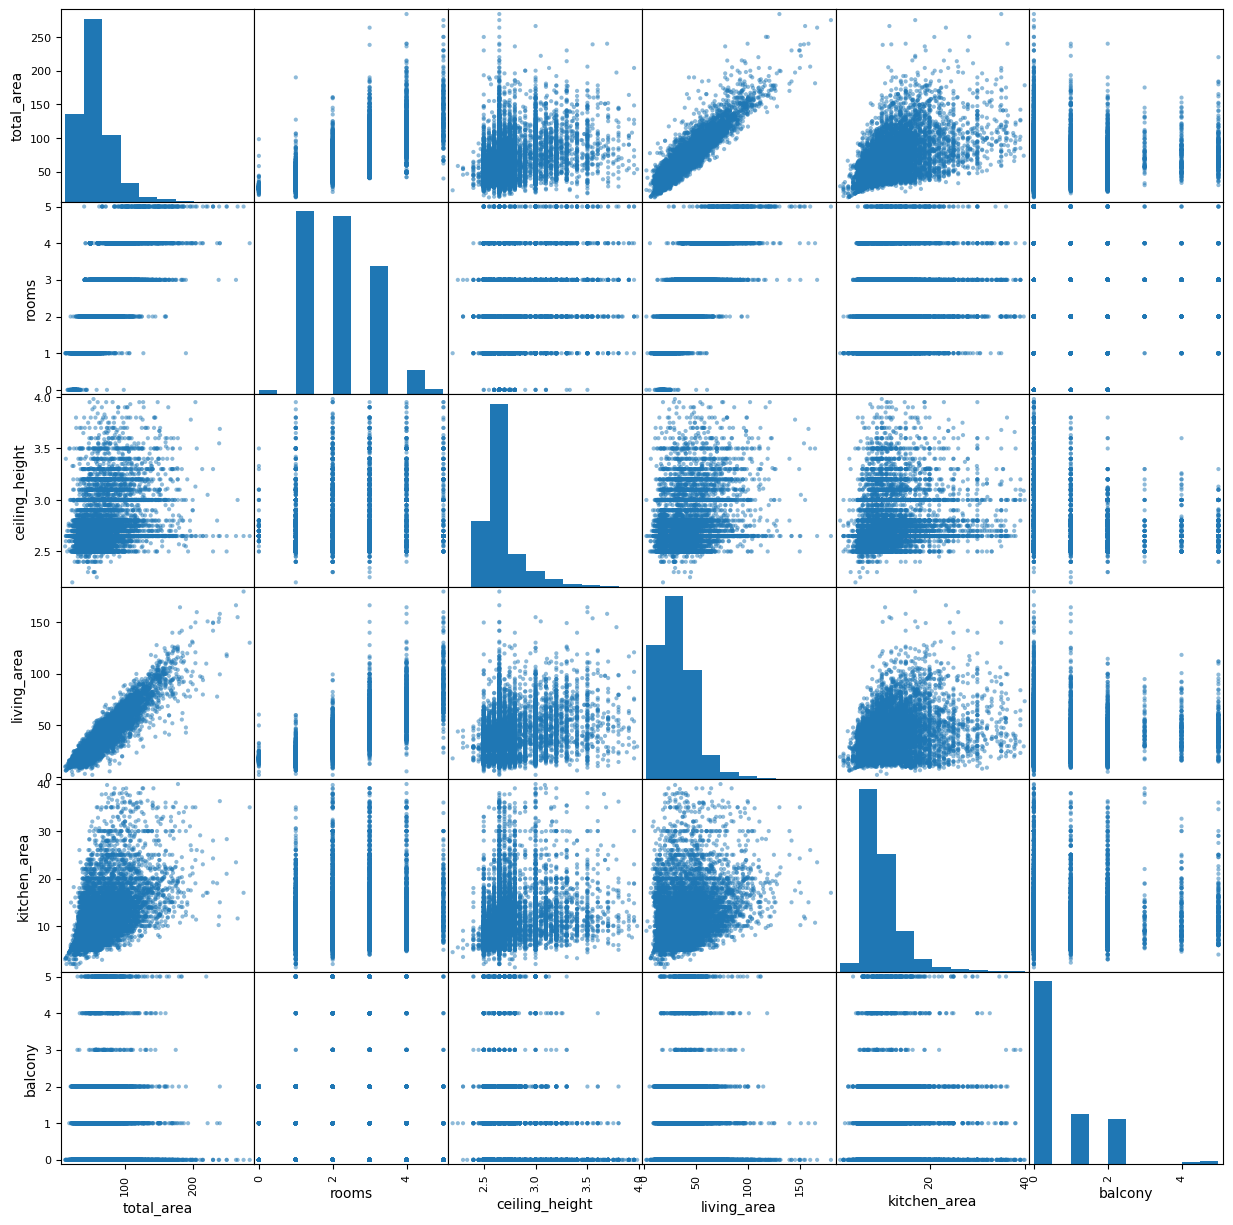

In [56]:
_ = pd.plotting.scatter_matrix(df[property_cols], figsize=(15, 15))

In [57]:
df[property_cols].corr()

,total_area,rooms,ceiling_height,living_area,kitchen_area,balcony
total_area,1.000000,0.782498,0.359937,0.931767,0.553904,0.037538
rooms,0.782498,1.000000,0.179562,0.862243,0.173357,-0.001889
ceiling_height,0.359937,0.179562,1.000000,0.315238,0.323243,-0.040990
living_area,0.931767,0.862243,0.315238,1.000000,0.333481,0.008060
kitchen_area,0.553904,0.173357,0.323243,0.333481,1.000000,0.072772
balcony,0.037538,-0.001889,-0.040990,0.008060,0.072772,1.000000


Видны довольно очевидные сильные (>0.75) положительные попарные корреляции между общей площадью, жилой площадью и количеством комнат. Интересно, что при этом корреляция между общей площадью и площадью кухни уже значительно более слабая (0.55), а между площадью кухни и количеством комнат и вовсе отсутствует.

Также наблюдается слабая положительная корреляция между высотой потолков, площадью кухни (0.32) и общей площадью (0.31). Возможно, это связано с тем, что сейчас стали строить более просторные квартиры с более крупными кухнями и высокими потолками. Жаль, что нет инфомрации о дате постройки домов, чтобы можно было проверить эту догадку.

Посмотрим еще на численные значения этих параметров.

In [58]:
df[property_cols].describe()

,total_area,rooms,ceiling_height,living_area,kitchen_area,balcony
count,22537.000000,22537.000000,22537.000000,22537.000000,22349.000000,22537.000000
mean,56.871623,2.004171,2.683972,32.644815,10.014208,0.595421
std,24.796700,0.955051,0.186383,16.557217,4.330860,0.958424
min,12.000000,0.000000,2.200000,2.000000,1.300000,0.000000
25%,40.000000,1.000000,2.600000,18.500000,7.000000,0.000000
50%,51.000000,2.000000,2.650000,30.000000,9.000000,0.000000
75%,67.300000,3.000000,2.700000,41.400000,11.400000,1.000000
max,284.000000,5.000000,3.980000,180.000000,39.900000,5.000000


Портрет средней квартиры получается таким: 2 комнаты, балкона нет, общая площадь 51 кв. м., из них жилая 30 кв. м., а кухня 9 кв. м. Высота потолка 2.65 м. Выходит описание какой-то средней хрущёвки (даже чуть урезанной, в хрущевках чаще всё же есть балкон).

Интересно посмотреть, есть ли какая-то разница в жилом фонде, продаваемом в Петербурге и городах области.

Посмотрим как респределены общая площадь и количество комнат в различных категориях населённых пунктов.

In [59]:
def column_of_plots(
    df: pd.DataFrame,
    cat_col: str,
    data_col: Optional[str] = None,
    kind: str = "scatter",
    xlabel: str = "",
    title: str = "",
    **kwargs
) -> None:
    """Функция для построения колонки гистрограмм по категориям."""
    fig, axs = plt.subplots(len(df[cat_col].unique()), 1, figsize=(8, 9), sharex=True)
    for i, category in enumerate(df[cat_col].sort_values().unique()):
        df[df[cat_col] == category].plot(
            kind=kind, y=data_col, label=category, ax=axs[i], grid=True, **kwargs
        )
        axs[i].set_title(category)

    plt.xlabel(xlabel)
    fig.suptitle(title)
    fig.tight_layout()

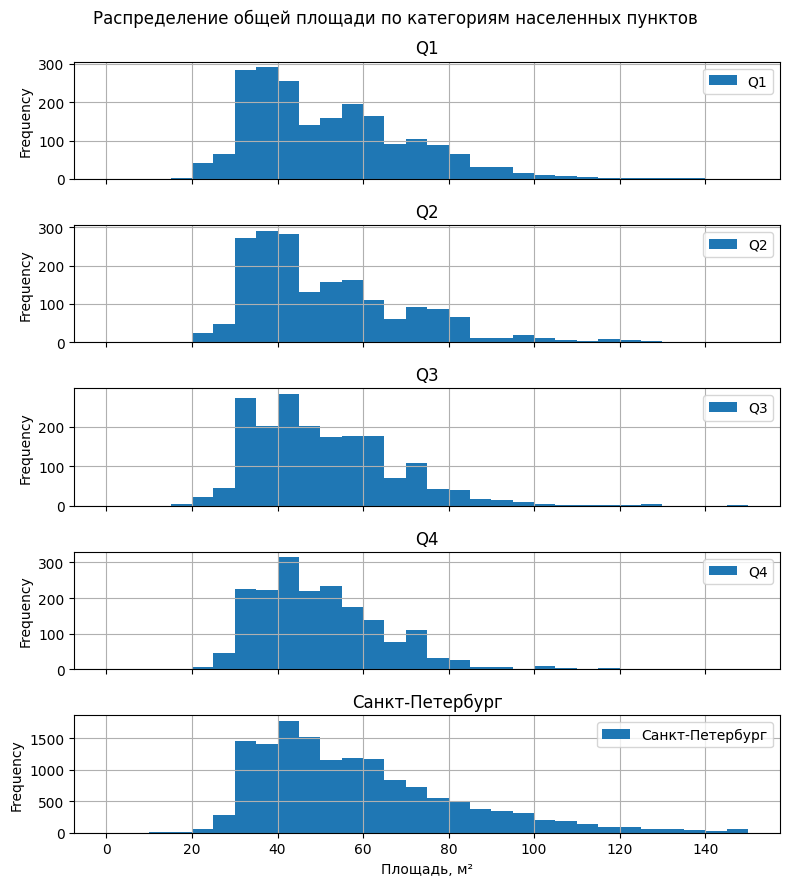

In [60]:
column_of_plots(
    df,
    cat_col="locality_cat",
    data_col="total_area",
    kind="hist",
    xlabel="Площадь, м²",
    title="Распределение общей площади по категориям населенных пунктов",
    range=(0, 150),
    bins=30,
)

В распределении площадей нет ничего интересного: все распределены примерно одинаково. В Санкт-Петербурге несколько больше крупных квартир, но разница не выглядит существенной.

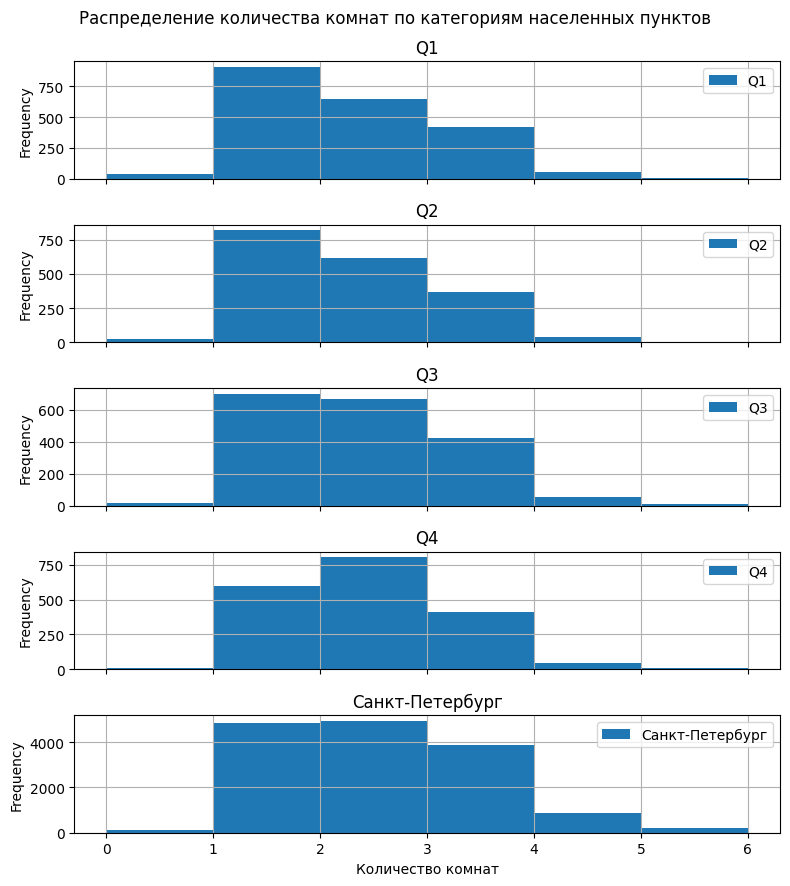

In [61]:
column_of_plots(
    df,
    cat_col="locality_cat",
    data_col="rooms",
    kind="hist",
    xlabel="Количество комнат",
    title="Распределение количества комнат по категориям населенных пунктов",
    range=(0, 6),
    bins=6,
)

In [62]:
df.pivot_table(
    index="locality_cat", columns="rooms", values="last_price", aggfunc="count"
).apply(lambda x: round(x / x.sum() * 100), axis=1)

rooms,0,1,2,3,4,5
locality_cat,,,,,,
Q1,2.0,44.0,31.0,20.0,3.0,0.0
Q2,1.0,44.0,33.0,20.0,2.0,0.0
Q3,1.0,37.0,36.0,22.0,3.0,1.0
Q4,0.0,32.0,43.0,22.0,2.0,0.0
Санкт-Петербург,1.0,33.0,33.0,26.0,6.0,1.0


А вот в распределении числа комнат есть небольшие забавные отличия:
* В более, чем половине наиболее крупных городов области преобладают 1-монатные квартиры.
* В Санкт-Петербурге примерно поровну продают 1 и 2-комнатные.
* А в самых мелких населённых пунктах превалируют 2-комнатные, но комнатки, видать, маленькие, площадь общая то не меняется :(

Давайте теперь посмотри на этажность зданий и на то, на каких этажах квартиры продаются.

Посмотри есть ли какие-то отличия для Петербурга и области.

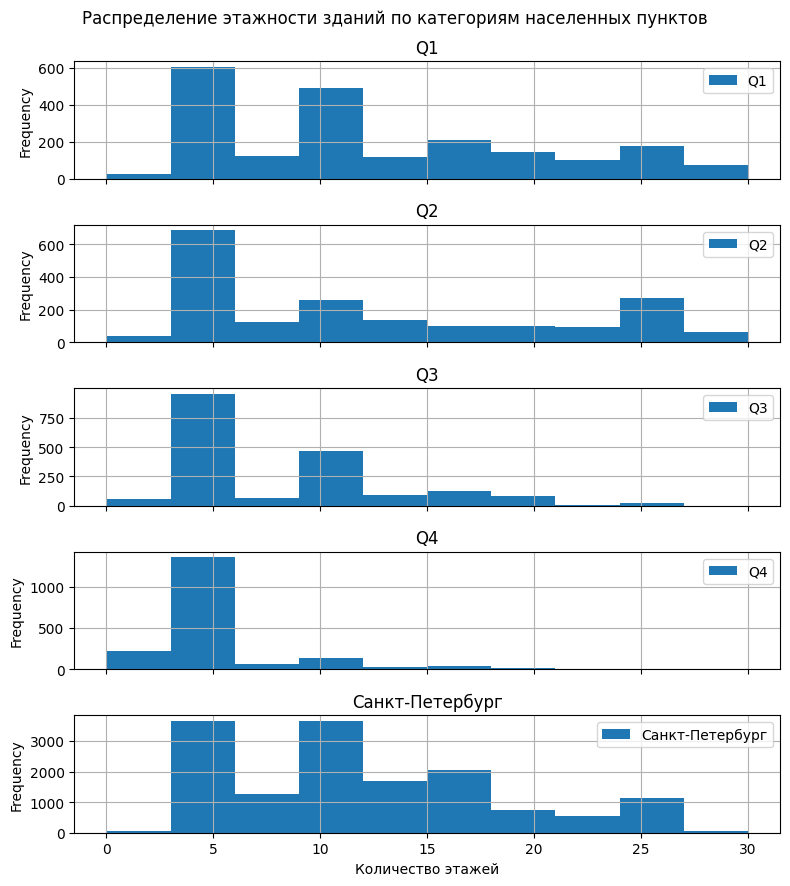

In [63]:
column_of_plots(
    df,
    cat_col="locality_cat",
    data_col="floors_total",
    kind="hist",
    xlabel="Количество этажей",
    title="Распределение этажности зданий по категориям населенных пунктов",
    range=(0, 30),
)

Во всех городах самым популярным домом является 5-этажки, а вторым по популярности 9-этажки (привет хрущёвкам).

Интересно, что распределение этажности зданий в Петербурге и половине самых крупных городов области, в общем-то, сопадают. А дальше количество объявлений в высокоэтажных домах стремительно падает и в 25% самых мелких населённых пунктах их практически, что, опять же, вполне логично: откуда взяться высотным домам в коттеджном помёлке, пгт или деревне?

Также В Петербурге и половине наиболее крупных городов выделяется пик 25-этажных домов.

Посмотрим распределение категори этажей.

In [64]:
towns_floor_cats = df.pivot_table(
    index="locality_cat", columns="floor_cat", values="last_price", aggfunc="count"
)
towns_floor_cats = towns_floor_cats.apply(lambda x: round(x / x.sum() * 100), axis=1)
towns_floor_cats

floor_cat,другой,первый,последний
locality_cat,,,
Q1,72.0,14.0,14.0
Q2,74.0,12.0,14.0
Q3,65.0,17.0,19.0
Q4,51.0,24.0,25.0
Санкт-Петербург,78.0,10.0,12.0


Количество объявление, предлагающих первый и последний этажи примерно одинаково везде.

Можно даже посчитать усреднённую этажность зданий по этим данным и сравнить её с данными об этажности зданий из объявлений. 

In [65]:
floors = df.pivot_table(index="locality_cat", values="floors_total", aggfunc="median")
floors["Calculated_aver_floors"] = 200 / (100 - towns_floor_cats["другой"])
floors

,floors_total,Calculated_aver_floors
locality_cat,,
Q1,9.0,7.142857
Q2,9.0,7.692308
Q3,5.0,5.714286
Q4,5.0,4.081633
Санкт-Петербург,9.0,9.090909


В Санкт-Петербурге совпадение практически идеальное, а вот в остальных городах этажность, вычисленные из категорий этажей оказалась ниже. Это может свидетельствовать о том, что квартиры с первых и последних этажей чаще выставляют на продажу, чем остальные квартиры.

Давайте теперь полоучим представление о том, как представлены данные по расстояниям до аэропорта и центра города и количеству парков.

Помним, что в этих столбцах у нас остались пропуски.

In [66]:
df[geoservice_cols].isna().sum()

airports_nearest        5440
cityCenters_nearest     5419
parks_around3000        5369
ponds_around3000        5369
parks_nearest          15129
ponds_nearest          14168
dtype: int64

При этом, для первых 4 категорий пропуски сосредоточены практически в одних и тех же объявлениях.

In [67]:
len(df.query(".isna() or ".join(geoservice_cols[:-2]) + ".isna()"))

5440

Даже можно сказать более конкретно: если пропущены данные о расстоянии до аэропорта, то нет и данных о расстоянии до центра города, парков и проудов.

In [68]:
df[~df["airports_nearest"].isna()][geoservice_cols].isna().sum()

airports_nearest          0
cityCenters_nearest       0
parks_around3000          0
ponds_around3000          0
parks_nearest          9706
ponds_nearest          8736
dtype: int64

Посмотрим как распределны по категориями населённых пунктов объявляения, в которых данные с геосервиса всё же есть.

In [69]:
geodata_present = df[~df["airports_nearest"].isna()].pivot_table(
    index="locality_cat", values="airports_nearest", aggfunc="count"
)
geodata_present["airports_nearest"] / df.groupby("locality_cat")[
    "last_price"
].count() * 100

locality_cat
Q1                 54.549855
Q2                 46.609717
Q3                 10.400000
Q4                  6.367041
Санкт-Петербург    99.522014
dtype: float64

Данные есть практически для всех объявлений Санкт-Петербурга и половины объявлений из крупных городов области. Для малых городов данные геосервиса практически не представлены.

Можно посмотреть как распределены количества парков и прудов в радиусе 3 км.

In [70]:
filtered_by_geo = df.query(
    'locality_cat != ["Q3", "Q4"] and not airports_nearest.isna()'
)

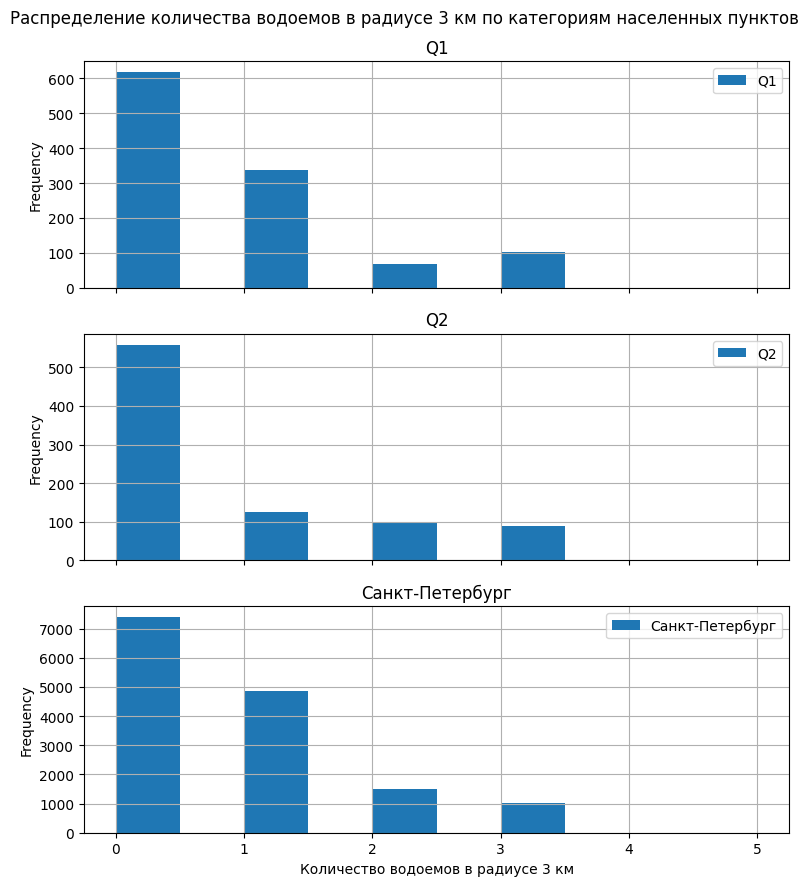

In [71]:
column_of_plots(
    filtered_by_geo,
    cat_col="locality_cat",
    data_col="ponds_around3000",
    kind="hist",
    xlabel="Количество водоемов в радиусе 3 км",
    title="Распределение количества водоемов в радиусе 3 км по категориям населенных пунктов",
    range=(0, 5),
)

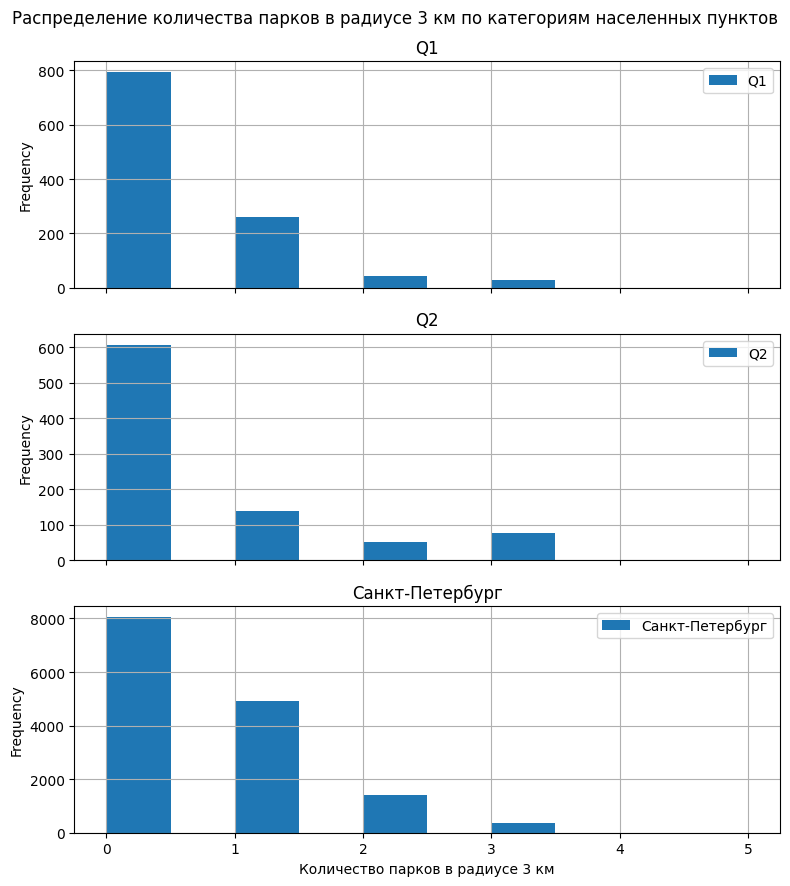

In [72]:
column_of_plots(
    filtered_by_geo,
    cat_col="locality_cat",
    data_col="parks_around3000",
    kind="hist",
    xlabel="Количество парков в радиусе 3 км",
    title="Распределение количества парков в радиусе 3 км по категориям населенных пунктов",
    range=(0, 5),
)

В обоих случаях картинка схожа: для большинства объявления вблизи нет ни парка ни пруда. В остальных же случаях чем мельче населённый пункт - тем меньше и парков и прудов. Прудов, кстати, чуть-чуть больше, чем парков.

Напоследок посмотрим как распределны объявления в Санкт-Петербурге по расстоянию от центра и расстоянию до аэропорта. 

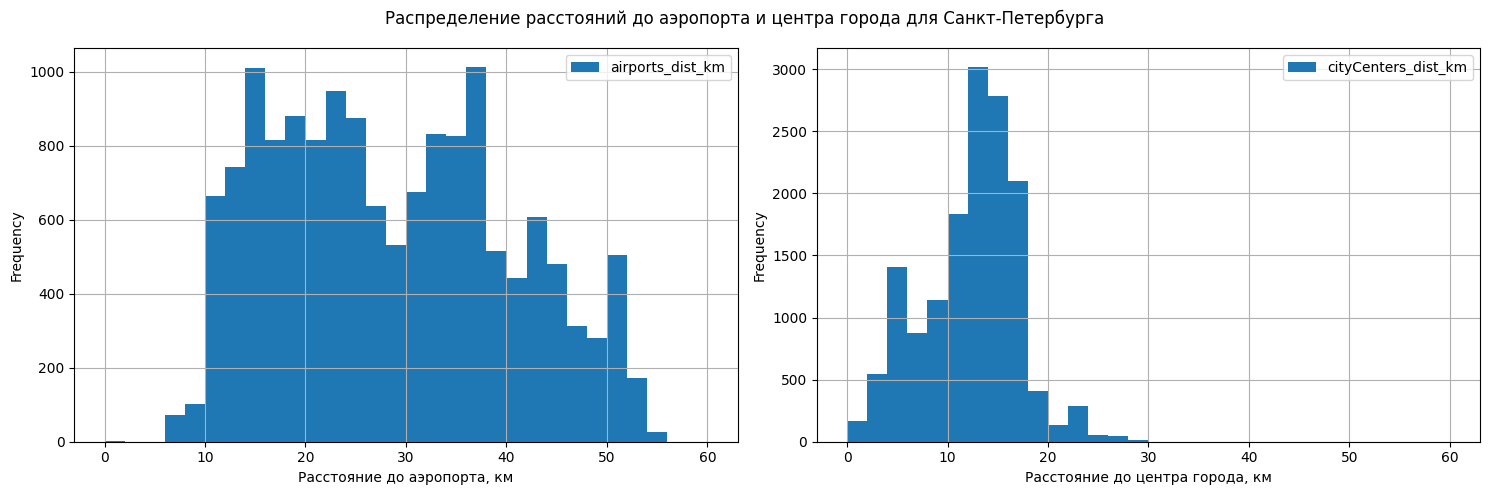

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
xlabels = ["Расстояние до аэропорта, км", "Расстояние до центра города, км"]
for i, cat in enumerate(["airports_dist_km", "cityCenters_dist_km"]):
    df[df["locality_name"] == "Санкт-Петербург"].plot(
        kind="hist",
        y=cat,
        label=cat,
        ax=axs[i],
        grid=True,
        bins=30,
        range=(0, 60),
        xlabel=xlabels[i],
    )

fig.suptitle(
    "Распределение расстояний до аэропорта и центра города для Санкт-Петербурга"
)
fig.tight_layout()

В распределении расстояний до центра города нет ничего интересного: большниство объявлений на расстоянии около 15 км от центра, скорее всег оспальные районы.

С распределением расстояний от аэропорта всё тоже закономерно: аэропорт один, и находится он на расстяонии примерно 30 км от центра города, это и объясняет провал в распределнии около 30 (ведь в центре очень мало объявлений как мы уже видели).

**Выводы**

Исследование свойств квартир в объявлениях привело к следующим основным результатам.

* Обнаружены сильные (>0.75) положительные попарные корреляции между общей площадью, жилой площадью и количеством комнат. При этом, корреляция между общей площадью и площадью кухни значительно более слабая (0.56), а между площадью кухни и количеством комнат и вовсе отсутствует (0.2).

* Наблюдается слабая положительная корреляция между высотой потолков, площадью кухни (0.31) и общей площадью (0.31). Возможно, это связано с тем, что сейчас стали строить более просторные квартиры с более крупными кухнями и высокими потолками.

* **Портрет средней квартиры по всем объявлениям**: 2 комнаты, балкона нет, общая площадь 51 кв. м., из них жилая 30 кв. м., а кухня 9 кв. м. Высота потолка 2.65 м.

* Площади квартир во всех категориях населённых пунктов распределены очень похоже. В Санкт-Петербурге несколько больше крупных квартир, но разница выглядит несущественной.

* В распределении числа комнат в объявлениях для различных категорий населённых пунктов присутствуют различия:
    * В более, чем половине наиболее крупных городов области преобладают 1-монатные квартиры.
    * В Санкт-Петербурге примерно поровну продают 1 и 2-комнатные (33%), 3-комнатные составляют при этом 26%.
    * А в самых мелких населённых пунктах превалируют 2-комнатные
    * Во всех категориях населённых пунктов квартиры с числом комнат более 3 составляют менее 7%.

* Во всех городах самым популярным домом является 5-этажки, а вторым по популярности 9-этажки.

  Распределение этажности зданий в Петербурге и половине самых крупных городов области сопадают. А дальше количество объявлений в высокоэтажных домах стремительно падает и в 25% самых мелких населённых пунктах их зданий выше 5 этажей практически нет.
  
  Также В Петербурге и половине наиболее крупных городов выделяется пик 25-этажных домов.

* Количество объявление, предлагающих первый и последний этажи примерно одинаково везде. В Санкт-Петербурге абсолютное значении доли таких квартир (10-12%) соответствует медианной высотности зданий города.
  
  В городах области доля первых и последних этажей выше, чем значение, которое можно было ожидать исходя из медианной этажности зданий. Это может свидетельствовать о том, что квартиры с первых и последних этажей чаще выставляют на продажу, чем остальные квартиры.

* Данные от геосервиса (расстояния до аэропорта, центра города, информация о парках и прудах) доступны для практически всех объявлений из Санкт-Петербурга и примерно для 50 % объявлений из наиболее крупных населённых пунктов области. Для более мелких городов количество этих данных несущественно и они не рассматривались.
  * Для большинства объявления вблизи нет ни парка ни пруда. В остальных же случаях чем мельче город - тем меньше и парков и прудов. Прудов, несколько больше, чем парков.
  * В Санкт-Петербурге большинство объявлений сосредоточено находится около 15 км от центра города. Распределение объявлений по расстоянию от аэропорта подтверждает эту картину.


[Оглавление](#0-bullet)

<a class="ancor" id="5-bullet"></a>

## Исследование длительности экспозиции квартир

При заполнении пропусков мы определили, что для времени экспозиции они означают, что квартира всё еще продаётся и не трогали их. Для этого раздела такие пропуски важны, поэтому надо на них еще раз внимательно посмотреть.

In [74]:
df.groupby("pub_year", dropna=False)["days_exposition"].agg(
    ["count", lambda x: x.isna().sum(), "median", "min", "max"]
)

,count,<lambda_0>,median,min,max
pub_year,,,,,
2014,79,15,718.0,554,1085
2015,921,58,532.0,182,1099
2016,2579,60,230.0,3,1091
2017,7585,237,103.0,3,814
2018,7346,888,63.0,3,465
2019,1054,1715,23.0,1,109


* Из анализа надо исключить объявления 2014 и 2019 годов. Первых просто очень мало, а для вторых слишком значительна доля пропусков (что мы трактуем как всё ещё не проданные квартиры), поэтому судить о длительности продажи по ним некорректно.
* Кроме того, крайне подозрительно выглядят и данные 2015 года: самая быстрая продажа для объявлений этого года заняла 182 дня. 2015 был, конечно, непростым годом, но всёравно такие данные выглядят невероятными и требуют дополнительной проверки, пока исключим их из анализа тоже.
* Для целей анализа данных в данном разделе самый консервативный способ заполнить пропуски - использовать максимальное значение для объявлений каждого года.

In [75]:
df_expo = df.query("pub_year.isna() or (pub_year > 2015 and pub_year < 2019)")
df_expo.loc[df_expo["days_exposition"].isna(), "days_exposition"] = df_expo.groupby(
    "pub_year"
)["days_exposition"].transform("max")

Для начала посмотрим на общее распределение длительности экспозиции.

count       18695.0
mean     180.827227
std      196.107428
min             3.0
25%            45.0
50%           104.0
75%           246.0
max          1091.0
Name: days_exposition, dtype: Float64

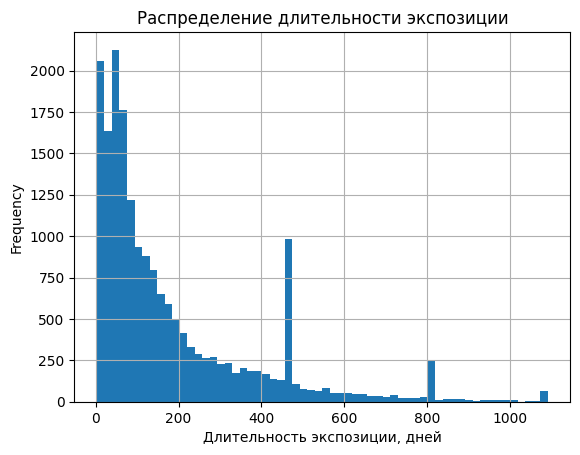

In [76]:
df_expo["days_exposition"].plot(
    kind="hist",
    bins=60,
    xlabel="Длительность экспозиции, дней",
    title="Распределение длительности экспозиции",
    grid=True,
)
df_expo["days_exposition"].describe()

Среднее значение (202) сильно превосходит медианное (113), это говорит о том, что на рынке много неликвидных квартир, которые очень долго экспонируются.

Посчитаем время, за которое осуществляется 10% самых быстрых и самых медленных продаж.

In [77]:
short = 0.10
long = 0.90
df_expo["days_exposition"].quantile([short, long])

0.1     20.0
0.9    465.0
Name: days_exposition, dtype: Float64

При выбранных нами определениях получается, что быстрой можно считать продажу в течение 21 дня, а долгой - в течение более, чем 470 дней.

Посмотри на эти данные с разбивкой по годам

In [78]:
expo_stat = df_expo.groupby("pub_year", dropna=False)["days_exposition"].agg(
    ["median", "min", "max", lambda x: x.quantile(short), lambda x: x.quantile(long)]
)
expo_stat.columns = ["median", "min", "max", "short", "long"]
expo_stat

,median,min,max,short,long
pub_year,,,,,
2016,242.0,3,1091,57,760
2017,108.0,3,814,20,434
2018,76.0,3,465,15,465


Рынок довольно быстро меняется по годам. Продажи происходят всё быстрее. На 2018 год медианная длительность экспозиции уже 76 дней, а быстрыми можно считать продажи за 15 дней.

Интересно посмотреть на гистограммы распределний длительности экспозиции по категориям населённых пунктов.

,median,min,max
locality_cat,,,
Q1,97.0,3,1091
Q2,97.0,3,1091
Q3,103.0,3,1091
Q4,136.0,3,1091
Санкт-Петербург,103.0,3,1091


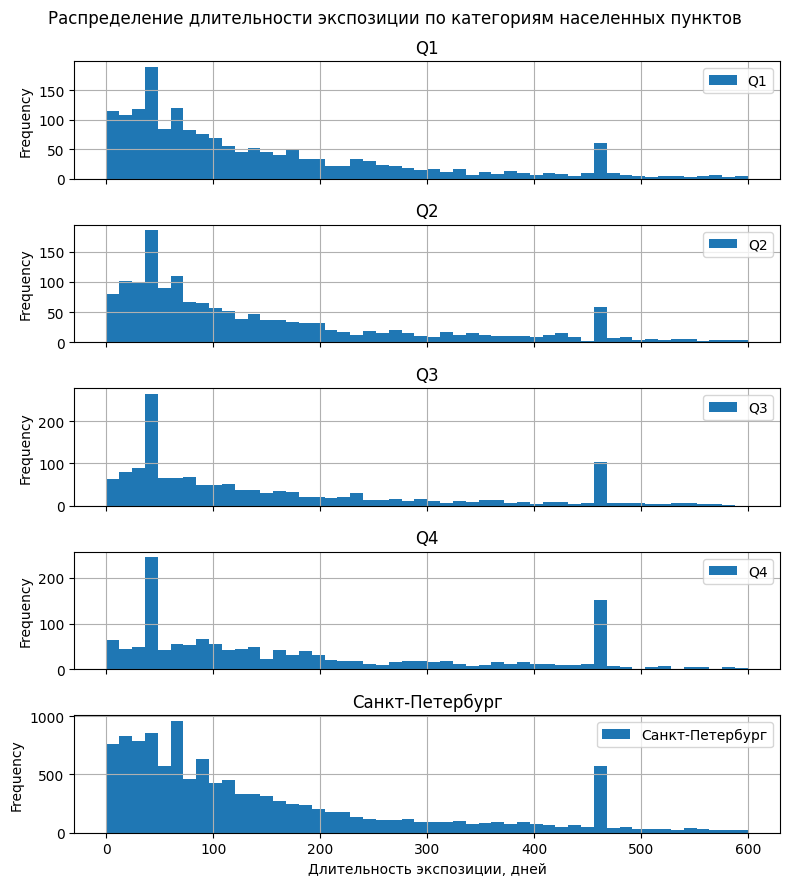

In [79]:
column_of_plots(
    df_expo,
    cat_col="locality_cat",
    data_col="days_exposition",
    kind="hist",
    xlabel="Длительность экспозиции, дней",
    title="Распределение длительности экспозиции по категориям населенных пунктов",
    range=(0, 600),
    bins=50,
)
df_expo.groupby("locality_cat")["days_exposition"].agg(["median", "min", "max"])

В Питере и наиболее крупных городах рынок поживее, а некливид есть везде.

Бросается в глаза пик на  ~50 днях, это реальные данные?

Надо посмотреть топ самых популярных времён экспозиции по категориям населенных пунктов.

In [80]:
vals_per_group = 4
# Специально используем исходные данные, чтобы не разбираться с заполнением пропусков
expo_by_local = df.groupby("locality_cat")["days_exposition"].value_counts()
new_index = [
    (x, y)
    for x in expo_by_local.index.get_level_values(0).unique()
    for y in expo_by_local[x].index[:vals_per_group]
]
expo_by_local[pd.MultiIndex.from_tuples(new_index)]

locality_cat     days_exposition
Q1               45                 104
                 60                  41
                 7                   24
                 44                  23
Q2               45                 103
                 60                  55
                 6                   15
                 13                  15
Q3               45                 185
                 7                   18
                 42                  17
                 44                  17
Q4               45                 173
                 44                  21
                 7                   16
                 60                  16
Санкт-Петербург  60                 404
                 45                 303
                 30                 166
                 7                  156
Name: count, dtype: Int64

Это действительно 45 дней, причем в Санкт-Петербурге и половине наиболее крупных городов еще отчётливо выделяется 60 дней...

Каких-то "естственных" причин почему такие сроки экспозиции выделяются не приходит в голову. Можно предположить, что 45 и 60 дней как-то связаны с внутренней логикой работы самого сервиса: например, это может быть время жизни объявлений "по умолчанию", после которого объявление снимается, если с ним не сделать определённых действий. Хорошо бы уточнить у команды сервиса объявлений имеют ли вроки 45 и 60 какое-то особое значение...

Посмотрим есть ли какие-то корреляции между длительностью экспозиции и параметрами объявлений

In [81]:
df_expo[numeric_cols].corr()["days_exposition"].sort_values(ascending=False, key=abs)

days_exposition        1.000000
total_area             0.173005
living_area            0.165024
last_price             0.153131
rooms                  0.134660
ceiling_height         0.109155
kitchen_area           0.091625
floors_total          -0.084850
parks_around3000       0.066718
floor                 -0.063964
total_images           0.060912
ponds_around3000       0.054401
ponds_nearest         -0.048122
cityCenters_dist_km   -0.042930
price_per_m2           0.037554
parks_nearest          0.029083
balcony               -0.026644
airports_dist_km      -0.014933
Name: days_exposition, dtype: float64

Прослеживается только умеренная отрицательная корреляция с годом публикации объявления: сделки с недвижимостью заключаются всё быстрее.

Но может мы не видим корреляций потому что смешали очень разные объявления из разных населённых пунктов? Надо посмотреть.

In [82]:
df_expo.pivot_table(
    index="locality_cat",
    values=numeric_cols,
    aggfunc=lambda x: x.corr(df["days_exposition"]),
).map(lambda x: x if abs(x) > 0.25 else None).dropna(axis=1, how="all")

,days_exposition,parks_nearest,ponds_nearest
locality_cat,,,
Q1,1.0,NaN,NaN
Q2,1.0,NaN,NaN
Q3,1.0,-0.734174,NaN
Q4,1.0,0.397325,0.390283
Санкт-Петербург,1.0,NaN,NaN


Показывает какие-то непонятные корреляции от расстояния до парков для маленьких населенных пунктов. А сколько вообще таких объявлений?

In [83]:
df[df["locality_cat"].isin(["Q3", "Q4"])][
    ["parks_nearest", "ponds_nearest"]
].dropna().count()

parks_nearest    53
ponds_nearest    53
dtype: int64

Таких объявлений очень мало, можно не обращать внимания.

Но мне всёравно независимость длительности экспозиции от параметров квартиры кажется контринтуитивным. Давайте еще сгруппируем по категориям населённых пунктов и цен за квадратный метр.

In [84]:
df_expo.pivot_table(
    index=["price_per_m2_cat", "locality_cat", "pub_year"],
    values="days_exposition",
    aggfunc=["count", "median", "mean"],
    observed=False,
).droplevel(1, axis=1).query("count > 200").sort_values("median")

count  median        mean
price_per_m2_cat locality_cat    pub_year                           
D                Санкт-Петербург 2018        737    63.0  110.236092
E                Q1              2018        211    65.0  120.597156
C                Санкт-Петербург 2018       1270    65.5  113.743307
D                Q1              2018        307    69.0   118.19544
B                Санкт-Петербург 2018       1457    71.0  119.889499
E                Q3              2018        531    75.0  149.491525
D                Санкт-Петербург 2017       1137    85.0  145.458223
                 Q2              2017        218    93.0  174.614679
A                Санкт-Петербург 2018       1631    95.0  165.211527
C                Санкт-Петербург 2017       1284    97.0       157.5
E                Q2              2017        204   103.0  153.936275
                 Q1              2017        259   104.0  151.949807
B                Санкт-Петербург 2017       1344   108.0  173.063988
D                Q1              2017        265   112.0  178.384906
E                Q4              2018        663   115.0  184.561086
                 Q3              2017        447   116.0  190.908277
                 Q4              2017        532   132.5  223.003759
A                Санкт-Петербург 2017       1296   134.0   221.12037
C                Санкт-Петербург 2016        434   196.5  307.327189
B                Санкт-Петербург 2016        425   232.0  324.202353
A                Санкт-Петербург 2016        427   238.0  360.552693
D                Санкт-Петербург 2016        416   260.0  327.865385

Начинает прослеживаться тенденция уменьшения длительности экспозиции при уменьшении цены квадратного метра, но всё еще доминирующим фактором остаётся год публикации объявления.

**Выводы**

При исследовании длительности экспозиции квартир на рынке были обнаружены дополнительные проблемы в данных:
* В годах до 2014 включительно слишком мало данных и они были исключены из анализа.
* В данных за 2015 обнаружена аномалия: самая быстрая продажа для объявлений этого года заняла 182 дня. Эти данные тоже были исключены из анализа.
* В данных за 2019 доля непроданных квартир составляет более 60%, использваоть такие данные для анализа длительности экспозиции квартир также некорректно, эти данные тоже были исключены из анализа.
* Итого, анализировались только данные за 2016-2018 года.
* Пропуски в данных по этим годам были заполнены максимальным значением длительности экспозиции для этих годов.
* Была обнаружена аномалия в длительности продаж квартир: в данных присутствует непропорционально большое количество квартир, проданых за 45 и 60 дней. Каких-то "естственных" причин почему такие сроки экспозиции выделяются не приходит в голову. Можно предположить, что 45 и 60 дней как-то связаны с внутренней логикой работы самого сервиса: например, это может быть время жизни объявлений "по умолчанию", после которого объявление снимается, если с ним не сделать определённых действий. Хорошо бы уточнить у команды сервиса объявлений имеют ли вроки 45 и 60 какое-то особое значение.

Были обнаружены следующие основные результаты:
* Среднее значение (202) сильно превосходит медианное (113), это говорит о том, что на рынке много неликвидных квартир, которые очень долго экспонируются.
* 10% самых быстрых продаж происходит за 21 день, а 10% самых медленных за 470 и более дней.
* Рынок довольно быстро меняется по годам. Продажи происходят всё быстрее. На 2018 год медианная длительность экспозиции уже 76 дней, а быстрыми можно считать продажи за 15 дней. Тогда как в 2016 году соответствующие значения равнялись 242 и 57 соответственно.
* При группировке данных по годам публикации объявлений и категориями населённых пунктов начинает прослеживаться тенденция уменьшения длительности экспозиции при уменьшении цены квадратного метра.Никаких существенных корреляций с другими параметрами объявлений обнаружено не было.

[Оглавление](#0-bullet)

<a class="ancor" id="6-bullet"></a>

## Исследование полной стоимости квартир

In [85]:
full_cost_cols = [
    "total_area",
    "living_area",
    "kitchen_area",
    "ceiling_height",
    "rooms",
    "cityCenters_dist_km",
    "pub_year",
    "pub_month",
    "pub_weekday",
]

Визуализируем зависимость полной цены продажи от численных параметров

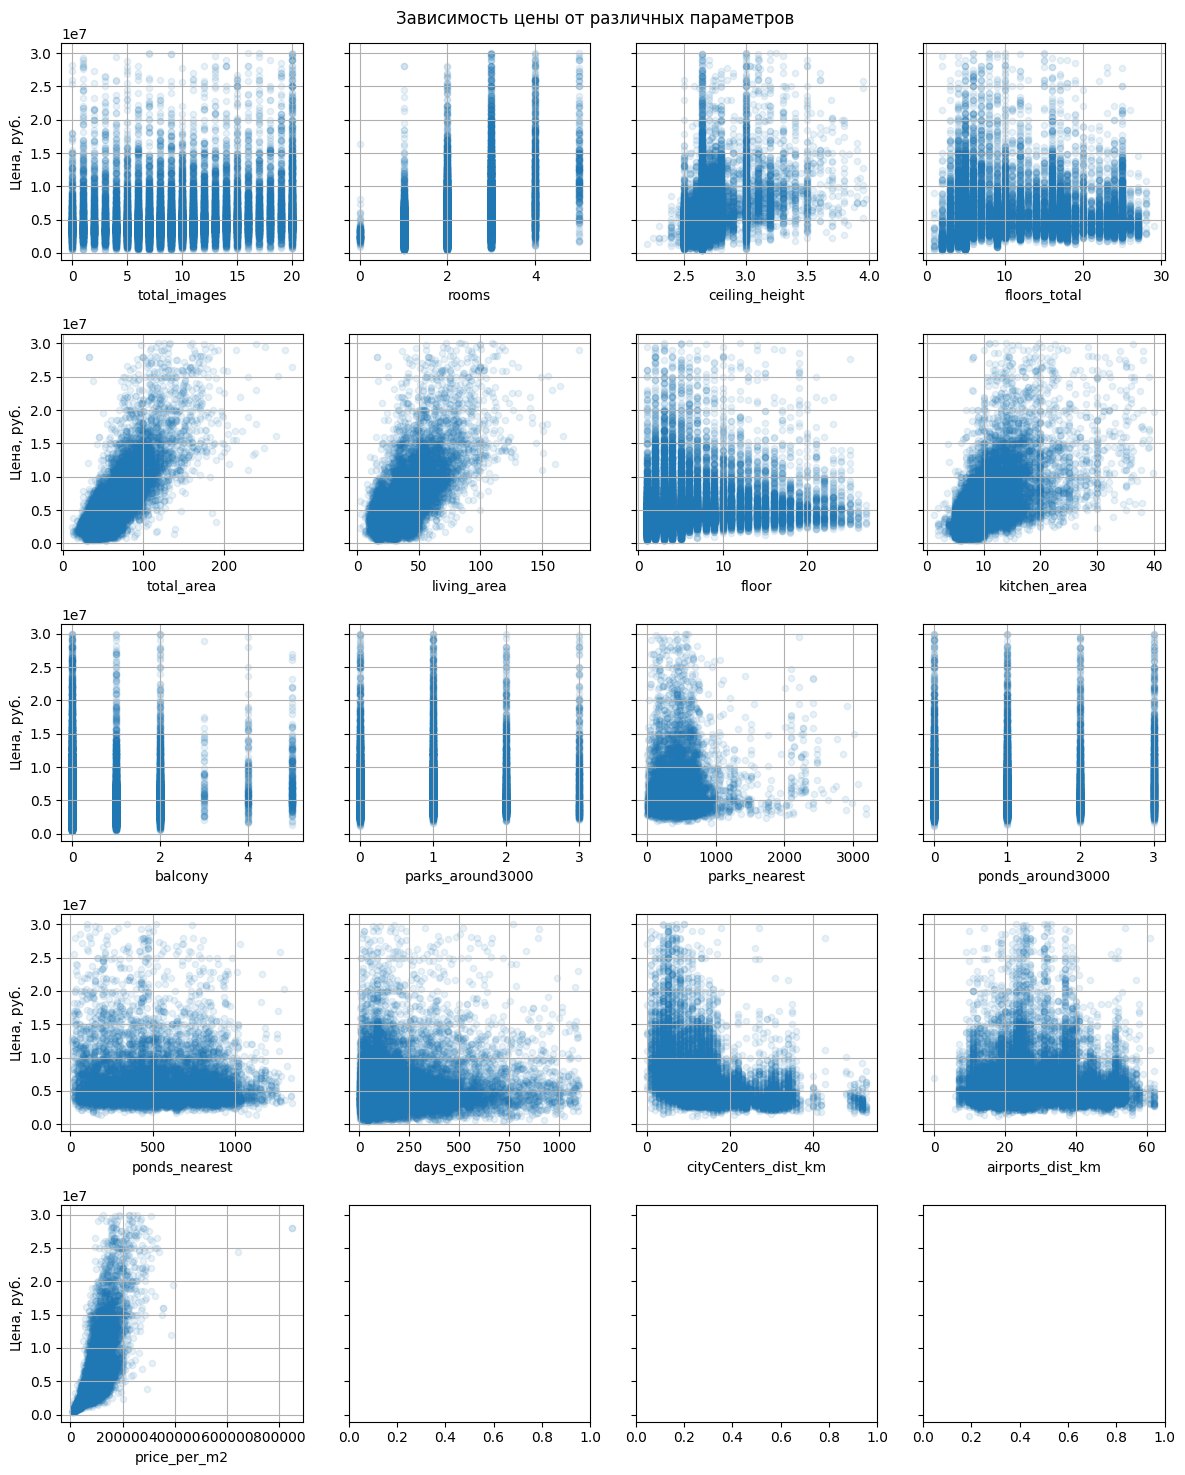

In [86]:
numeric_without_price = numeric_cols.copy()
numeric_without_price.remove("last_price")

ncols = 4
nrows = math.ceil(len(numeric_without_price) / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharey=True)
# Упрощаем итерацию по осям
axs = axs.flatten()

for i, col in enumerate(numeric_without_price):
    df.plot(
        kind="scatter",
        x=col,
        y="last_price",
        ax=axs[i],
        grid=True,
        alpha=0.1,
        xlabel=col,
        ylabel="Цена, руб.",
    )
fig.suptitle("Зависимость цены от различных параметров")
fig.tight_layout()

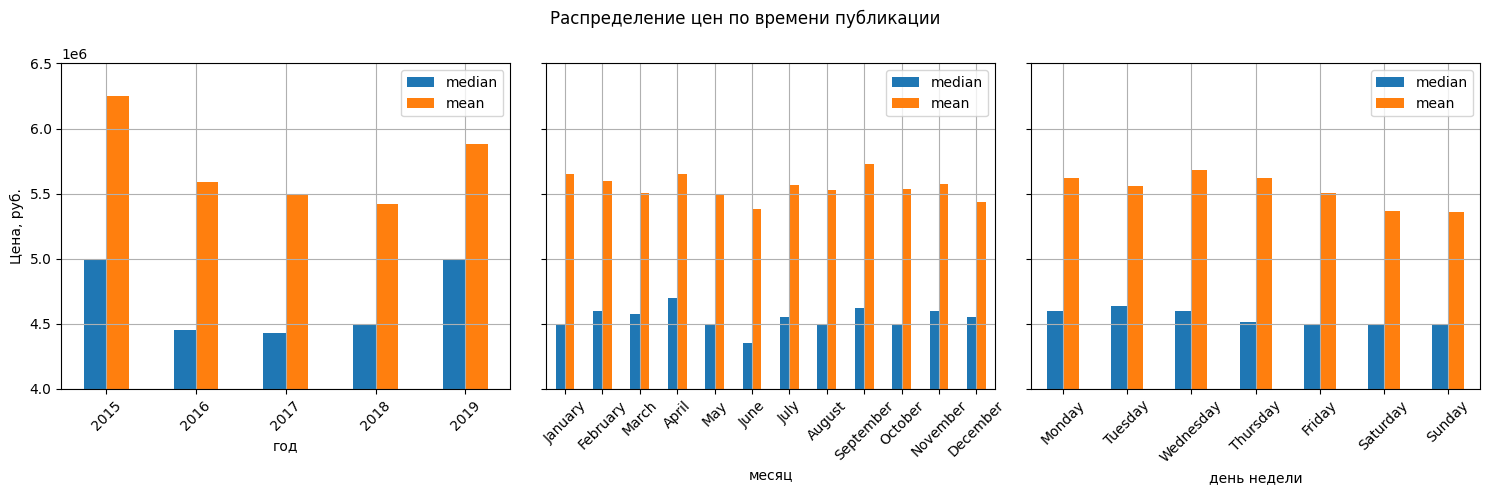

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
titles = ["год", "месяц", "день недели"]
for i, col in enumerate(["pub_year", "pub_month", "pub_weekday"]):
    df[df["pub_year"] > 2014].pivot_table(
        index=col, values="last_price", aggfunc=["median", "mean"], observed=False
    ).droplevel(1, axis=1).plot(
        kind="bar",
        ax=axs[i],
        grid=True,
        xlabel=titles[i],
        ylabel="Цена, руб.",
        ylim=(4e6, 6.5e6),
        rot=45,
    )
fig.suptitle("Распределение цен по времени публикации")
fig.tight_layout()

In [88]:
df.groupby("pub_year", observed=False)["last_price"].agg(["count", "median", "mean"])

,count,median,mean
pub_year,,,
2014,94,6950000.0,9.073211e+06
2015,979,5000000.0,6.248142e+06
2016,2639,4450000.0,5.592822e+06
2017,7822,4431742.0,5.496451e+06
2018,8234,4500000.0,5.418406e+06
2019,2769,5000000.0,5.881946e+06


Данных по 2014 слишком мало, не будем на них ориентриоваться.

Тем не менее, явно прослеживается падение цен в 2016 году почти на 10%, стабилизация цен в течение следующих двух лет и рост в 2019 примерно на 10% до уровня 2015 года. 

In [89]:
df[df["pub_year"] > 2014].groupby("pub_month", observed=False)["last_price"].agg(
    ["count", "median", "mean"]
).sort_values("median", ascending=False)

,count,median,mean
pub_month,,,
April,2268,4700000.0,5.649798e+06
September,1887,4620000.0,5.728904e+06
November,2230,4600000.0,5.574009e+06
February,2518,4600000.0,5.595608e+06
March,2450,4575000.0,5.503254e+06
July,1611,4550000.0,5.563378e+06
December,1465,4550000.0,5.434000e+06
January,1431,4500000.0,5.651790e+06
May,1211,4500000.0,5.497185e+06


In [90]:
df[df["pub_year"] > 2014].groupby("pub_month", observed=False)[
    "last_price"
].median().agg(["min", "max", lambda x: (1 - x.max() / x.min()) * 100])

min         4.350000e+06
max         4.700000e+06
<lambda>   -8.045977e+00
Name: last_price, dtype: float64

Вариативность медианной цены по месяцам составляет 8%. Самое высокое значение достигается в апреле, а минимальное в июне. Также повышенное значение медианной цены продажи наблюдается в сентябре, ноябре и феврале.

In [91]:
df.groupby("pub_weekday", observed=False)["last_price"].agg(["count", "median", "mean"])

,count,median,mean
pub_weekday,,,
Monday,3468,4600000.0,5.626712e+06
Tuesday,3974,4650000.0,5.588774e+06
Wednesday,3777,4600000.0,5.690114e+06
Thursday,4037,4550000.0,5.653867e+06
Friday,3824,4500000.0,5.504054e+06
Saturday,1844,4500000.0,5.364962e+06
Sunday,1613,4500000.0,5.359473e+06


In [92]:
df[df["pub_year"] > 2014].groupby("pub_weekday", observed=False)[
    "last_price"
].median().agg(["min", "max", lambda x: (1 - x.max() / x.min()) * 100])

min         4.500000e+06
max         4.636000e+06
<lambda>   -3.022222e+00
Name: last_price, dtype: float64

Вариативность по дням недели еще ниже и составляет всего 3%. Наиболее высокие значения наблюдаются при публикации объявлений в первую половину недели с понедельника по среду.

Видно, что цена продажи явно коррелирует с некоторыми параметрами, посмотрим на численные значения этих корреляций.

In [93]:
df[numeric_cols].corr()["last_price"].sort_values(ascending=False, key=abs)

last_price             1.000000
total_area             0.777931
living_area            0.677513
price_per_m2           0.672064
kitchen_area           0.589635
rooms                  0.485911
ceiling_height         0.417354
cityCenters_dist_km   -0.352251
ponds_around3000       0.198966
parks_around3000       0.181288
total_images           0.153302
days_exposition        0.109288
ponds_nearest         -0.104178
floors_total           0.095561
floor                  0.088002
parks_nearest          0.046278
balcony                0.040762
airports_dist_km      -0.023128
Name: last_price, dtype: float64

Самая сильная корреляция (0.77) между ценой и общей площадью. Также видны средние положительные корреляции между ценой и жилой площадью, площадью за квадратный метр и площадью кухни, что в целом не удивительно, учитывая установленные ранее корреляции между площадями квартир.

Имеется также несколько слабых корреляций. 2 положительные с количеством комнат и высотой потолков и одна отрицательная с расстоянием до центра города.

Но мы здесь смотрим на довольно разные категории населённых пунктов, давайте лучше посмотрим на корреляции при группировке по категориям населённых пунктов.

Посмотрим просто на список категория, с которыми есть хотябы слабая корреляция (abs > 0.3)

In [94]:
tot_price_per_loc = (
    df[numeric_cols + ["locality_cat"]]
    .groupby("locality_cat")
    .corr()["last_price"]
    .map(lambda x: x if abs(x) > 0.3 and abs(x) < 1 else None)
    .dropna()
    .sort_values(ascending=False, key=abs)
)

tot_price_per_loc

locality_cat                        
Санкт-Петербург  total_area             0.816654
Q1               total_area             0.762262
Q2               total_area             0.747941
Санкт-Петербург  living_area            0.716605
Q3               total_area             0.683424
Q1               living_area            0.682807
Q4               price_per_m2           0.678591
                 total_area             0.640610
Q2               living_area            0.637716
Санкт-Петербург  kitchen_area           0.612437
Q3               price_per_m2           0.599841
Санкт-Петербург  price_per_m2           0.593395
Q1               rooms                  0.547546
Q3               living_area            0.543725
Q2               rooms                  0.538154
                 kitchen_area           0.529492
Q4               kitchen_area           0.528914
Санкт-Петербург  rooms                  0.523774
Q4               living_area            0.521418
Q3               kitchen_area   

В целом, картина особо не поменялась.

Посмотрим на зависимость цен от категориальных данных и начнем с категорий населённых пунктов.

,count,median,mean
,last_price,last_price,last_price
locality_cat,,,
Q1,2066,3750000.0,4.216034e+06
Q2,1873,3750000.0,4.203211e+06
Q3,1875,2750000.0,2.881234e+06
Q4,1869,2200000.0,2.469687e+06
Санкт-Петербург,14854,5400000.0,6.666465e+06


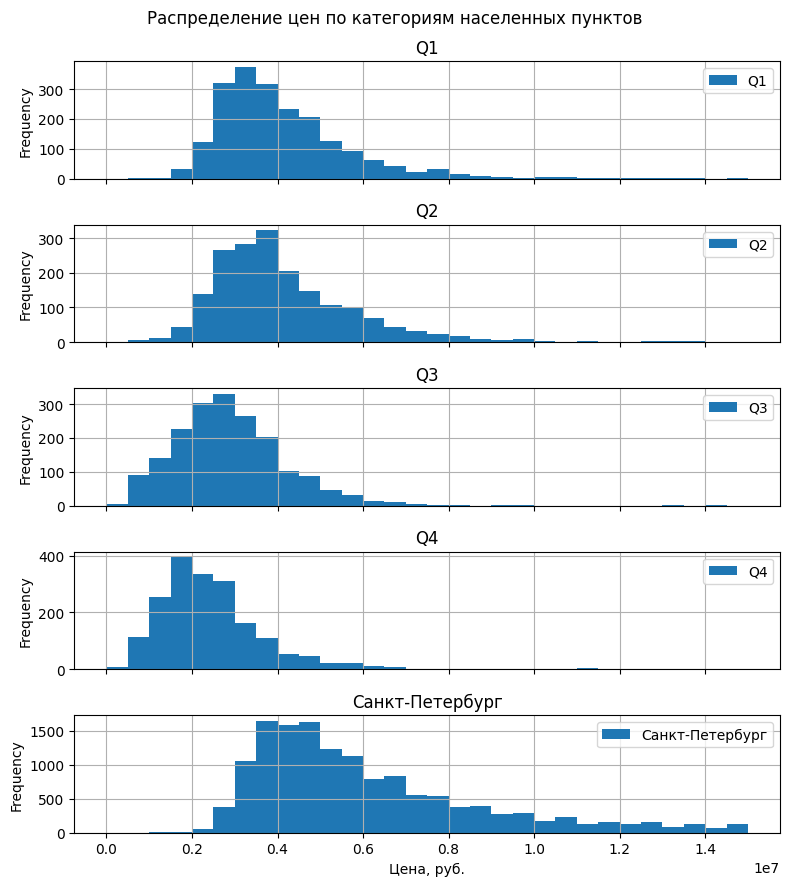

In [95]:
column_of_plots(
    df,
    cat_col="locality_cat",
    data_col="last_price",
    kind="hist",
    xlabel="Цена, руб.",
    title="Распределение цен по категориям населенных пунктов",
    bins=30,
    range=(0, 1.5e7),
)
df.pivot_table(
    index="locality_cat",
    values="last_price",
    aggfunc=["count", "median", "mean"],
)

Как видно, различия очень сильные.
В Санкт-Петербурге медианная цена составляет 5.4 млн, в половине наиболее крупных населённых пунктов 3.75 млн, в Q3 - 2.75 млн, а в Q4 всего 2.2 млн. Разница в 2.5 раза.

Посмотрим теперь как цена зависит от категории этажа.

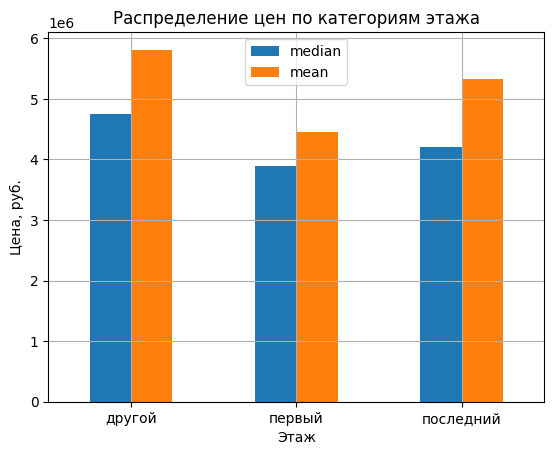

In [96]:
_ = df.pivot_table(
    index="floor_cat",
    values="last_price",
    aggfunc=["median", "mean"],
).droplevel(1, axis=1).plot(
    kind="bar",
    grid=True,
    xlabel="Этаж",
    ylabel="Цена, руб.",
    rot=0,
    title="Распределение цен по категориям этажа",
)

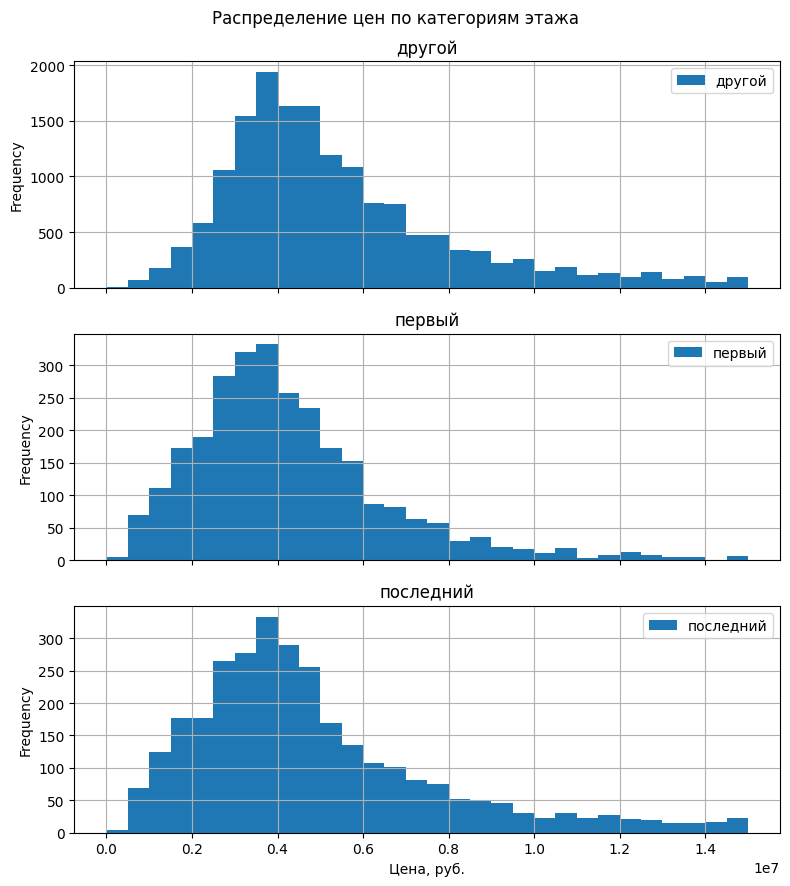

In [97]:
column_of_plots(
    df,
    cat_col="floor_cat",
    data_col="last_price",
    kind="hist",
    xlabel="Цена, руб.",
    title="Распределение цен по категориям этажа",
    bins=30,
    range=(0, 1.5e7),
)

Видно, что цена квартир на первом этаже несколько ниже, чем на более высоких этажах.

Давайте посмотрим цифры. Однако влияние категории очень велико и наверно неправильно будет его игнорировать, поэтому учтём и категории этажей и категории населенных пунктов.

In [98]:
df.pivot_table(
    index="floor_cat",
    columns="locality_cat",
    values="last_price",
    aggfunc=lambda x: round(x.median() / 1e6, 1),
)

locality_cat,Q1,Q2,Q3,Q4,Санкт-Петербург
floor_cat,,,,,
другой,3.7,3.9,2.9,2.4,5.5
первый,3.8,3.4,2.4,2.0,4.8
последний,4.1,3.4,2.5,2.0,5.4


Картина не вполне однозначная. В большинстве случаев квартиры на первом этаже действительно стоят дешевле, исключение города Q1, где они стоят практически столько же, сколько и квартиры на средних этажах.

Квартиры на средних этажах обычно самые дорогие, но в Санкт-Петербурге их стоимость практически равна стоимости квартир на последнем этаже, а в Q1 квартиры на последнем этаже и вовсе самые дорогие.

Я думаю, что объяснение этому - ценность последнего этажа в высотных домах (выше 9 этажей). Давайте проверим это.

In [99]:
df.query('floors_total > 9 and locality_cat == "Санкт-Петербург"').pivot_table(
    index="floor_cat",
    columns="locality_cat",
    values="last_price",
    aggfunc=["count", lambda x: round(x.median() / 1e6, 1)],
)

,count,<lambda>
locality_cat,Санкт-Петербург,Санкт-Петербург
floor_cat,,
другой,6401,5.8
первый,350,5.1
последний,452,6.0


Действительно, цена квартир на последнем этаже вышла на первое место.

**Выводы**

Исследование полной стоимости квартир выявило следующие основные результаты:
* Самая сильная корреляция (0.77) обнаружена между стоимостью и общей площадью.
* Наблюдается сильная зависимость общей стоимости от категории населенного пункта. В Санкт-Петербурге медианная цена составляет 5.4 млн, в половине наиболее крупных населённых пунктов 3.75 млн, в Q3 - 2.75 млн, а в Q4 всего 2.2 млн. Разница в 2.5 раза.
* Наблюдаются средние корреляции между стоимостью и жилой площадью (0.68), ценой за квадратный метр (0.67) и площадью кухни (0.59).
* Имеется также несколько слабых корреляций общей стоимости. 2 положительные с количеством комнат (0.49) и высотой потолков (0.42) и одна отрицательная с расстоянием до центра города (-0.35).
* Зависимость полной стоимости квартиры от категории этажа не вполне однозначна. В большинстве случаев квартиры на первом этаже стоят дешевле, исключение города Q1, где они стоят практически столько же, сколько и квартиры на средних этажах.

    Квартиры на средних этажах обычно самые дорогие, но в Санкт-Петербурге их стоимость практически равна стоимости квартир на последнем этаже, а в Q1 квартиры на последнем этаже и вовсе самые дорогие. Вероятно это связано с ценностью высоких этажей в высотных домах. Эта гипотеза подтверждается в Санкт-Петербурге, где в домах выше 9 этажей мединная стоимость квартир на последнем этаже выше, чем на других этажах.
* Явно прослеживается падение цен в 2016 году почти на 10% по сравнению с 2015 годом, стабилизация цен в течение следующих двух лет и рост в 2019 примерно на 10% до уровня 2015 года. 
  
    Вариативность медианной цены по месяцам составляет 8%. Самое высокое значение достигается в апреле, а минимальное в июне. Также повышенное значение медианной цены продажи наблюдается в сентябре, ноябре и феврале.

    Вариативность по дням недели еще ниже и составляет всего 3%. Наиболее высокие значения наблюдаются при публикации объявлений в первую половину недели с понедельника по среду.

[Оглавление](#0-bullet)

<a class="ancor" id="7-bullet"></a>

## Исследование стоимости квадратного метра

Для общей цены Самые большие корреляции были с общей площадью и категорией населенного пункта, поэтому вхожие зависимости можно ожидать и для цены квадратного метра.

Начнем с зависимости от категории населённого пункта.

,count,median,mean
,price_per_m2,price_per_m2,price_per_m2
locality_cat,,,
Q1,2066,79567.0,82166.364472
Q2,1873,82228.0,82862.955152
Q3,1875,59302.0,57910.124267
Q4,1869,46575.0,49503.516854
Санкт-Петербург,14854,103996.5,110213.067053


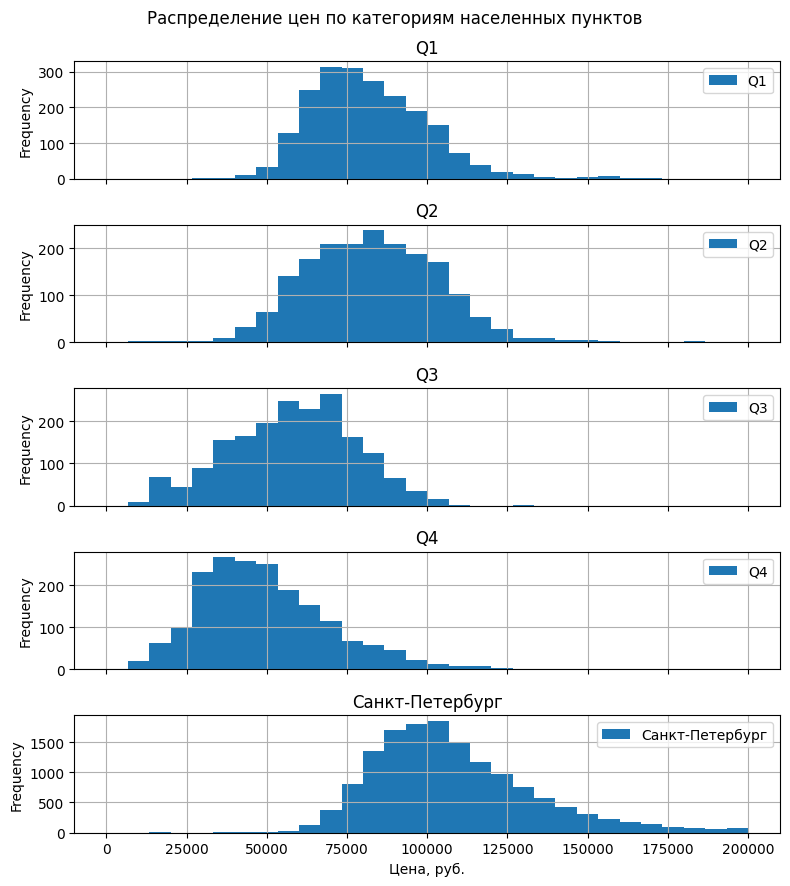

In [100]:
column_of_plots(
    df,
    cat_col="locality_cat",
    data_col="price_per_m2",
    kind="hist",
    xlabel="Цена, руб.",
    title="Распределение цен по категориям населенных пунктов",
    bins=30,
    range=(0, 2e5),
)
df.pivot_table(
    index="locality_cat",
    values="price_per_m2",
    aggfunc=["count", "median", "mean"],
)

Как и ожидалась, картина схожа со случаем для полной цены.

Средняя цена квадрата в Питере около 100 т.р., в половине наиболее крупных городов около 80 т.р., в Q3 - 60, а в Q4 - 46 т.р.

Посмотри заодно стоимость квадратного метра из топ-10 городов по количеству объявлений

In [101]:
df.pivot_table(
    index="locality_name",
    values="price_per_m2",
    aggfunc=["count", "median", "mean"],
).droplevel(1, axis=1).sort_values("count", ascending=False).head(10)

,count,median,mean
locality_name,,,
Санкт-Петербург,14854,103996.5,110213.067053
поселок Мурино,547,86076.0,85661.025594
поселок Шушары,437,76829.0,78534.940503
Всеволожск,392,65789.0,68670.543367
Пушкин,354,99725.5,102700.822034
Колпино,336,74690.0,75310.758929
поселок Парголово,324,91780.5,90296.027778
Гатчина,304,67926.0,68818.391447
деревня Кудрово,294,91735.0,92256.377551


Ожидаемо самая высокая цена квадратного метра в Санкт-Петербурге. Лишь чуть уступает цена квардатного метра в Пушкине, что, в целом, тоже ожидаемо для города парков и Царского Села.

Самая низкая цена с некоторым отрывом - Выборг, что, опять же, ожидаемо, так как этот город - самый удалённый от Санкт-Петербурга из топ-10.

Интересно посмотреть с чем коррелирует цена квадратного метра. Из-за сильно зависимости от категории населённого пункта, будем сначала выделять категорию населенного пункта и только потом считать корреляции.

In [102]:
df[numeric_cols + ["locality_cat"]].groupby("locality_cat").corr(min_periods=1000)[
    "price_per_m2"
].map(lambda x: x if abs(x) > 0.3 and abs(x) < 1 else None).dropna().sort_values(
    ascending=False, key=abs
)

locality_cat                        
Q4               last_price             0.678591
Q3               last_price             0.599841
Санкт-Петербург  last_price             0.593395
Q3               floors_total           0.510130
Q1               last_price             0.474125
Q2               last_price             0.469858
                 floors_total           0.420421
Q4               floors_total           0.380067
Q3               floor                  0.347952
Санкт-Петербург  cityCenters_dist_km   -0.337537
                 kitchen_area           0.314055
Q2               floor                  0.312066
Q1               airports_dist_km      -0.309268
Name: price_per_m2, dtype: float64

С ценой квадрата сильнее всего коррелирует общая цена, что не очень очевидно, так казалось бы, что в маленьких квартирах квадратный метр обычно дороже.

Совсем неожиданным выглядит вторая по величине положительная корреляция с общим количеством этажей.

В Санкт-Петербурге еще есть слабая положительная корреляция с площадью кухни и отрицательная с расстоянием до центра города.

**Исследование стоимости квадратного метра**

Изучение стоимости квадратного метра дало следующие результаты:

* Средняя стоимость квадратного метра сильно зависит от категории населённого пункта. Средняя цена квадрата в Питере около 100 т.р., в половине наиболее крупных городов около 80 т.р., в Q3 - 60, а в Q4 - 46 т.р.
* Ожидаемо, самая высокая цена квадратного метра в Санкт-Петербурге. Лишь чуть уступает цена квардатного метра в Пушкине, что, в целом, тоже ожидаемо для города парков и Царского Села.

    Самая низкая цена среди топ-10 городов по количеству объявлений - Выборг, что, вероятно связано с тем, что этот город - самый удалённый от Санкт-Петербурга.
* Среди численных параметров с ценой квадрата сильнее всего коррелирует общая цена (0.46-0.68).
* Также значительная корреляция (0.38-0.51) наблюдается с общим количеством этажей.
* В Санкт-Петербурге наблюдается слабая положительная корреляция с площадью кухни (0.31) и отрицательная с расстоянием до центра города (-0.34).

[Оглавление](#0-bullet)

<a class="ancor" id="8-bullet"></a>

## Исследование влияния удалённости квартиры от центра города 

Посмотрим на зависимость стоимости квартир от удалённости от центра города в Санкт-Петербурге.

In [103]:
df_spb = df.query('locality_name == "Санкт-Петербург"')

df_spb.pivot_table(
    index="cityCenters_dist_km",
    values="last_price",
    aggfunc=["count", "median", "mean"],
)

,count,median,mean
,last_price,last_price,last_price
cityCenters_dist_km,,,
0,13,9590000.0,1.129077e+07
1,150,9900000.0,1.106653e+07
2,247,9200000.0,1.050054e+07
3,302,8000000.0,9.279034e+06
4,609,8550000.0,9.967101e+06
5,796,8700000.0,1.043240e+07
6,520,7988000.0,9.278066e+06
7,352,6887027.5,9.058740e+06


Визуализируем зависимость медианной цены от расстояния. Учтём, что для 0 км расстояний более 24 км данных слишком мало, поэтому не будем их строить.

<Axes: title={'center': 'Зависимость цены от расстояния до центра города'}, xlabel='Расстояние до центра города, км', ylabel='Цена, руб.'>

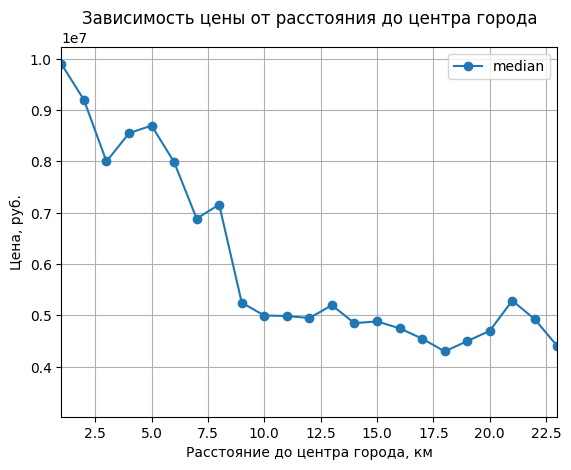

In [104]:
df_spb.pivot_table(
    index="cityCenters_dist_km",
    values="last_price",
    aggfunc=["count", "median", "mean"],
).droplevel(1, axis=1).plot(
    kind="line",
    y="median",
    grid=True,
    xlabel="Расстояние до центра города, км",
    ylabel="Цена, руб.",
    xlim=(1, 23),
    style="-o",
    title="Зависимость цены от расстояния до центра города",
)

**Выводы**

На расстояниях до 10 км общая стоимость сильно зависит от расстояния до центра города (медианная цена уменьшается в 2 раза от 10 до 5 млн). Далее цены практически не зависят от расстояния.

[Оглавление](#0-bullet)

<a class="ancor" id="9-bullet"></a>

## Общий вывод

**Предобработка данных выявила несколько проблем:**
* Множественные пропуски в данных:
    * Пропуски в категиории "высота потолков" были заполнены медианным значением по всему датасету.
    * Пропуски в жилой площади и площади кухни были заменены значениями, вычисленными как произведение общей площади на медианное отношение пропущенной площади к общей площади для квартир с таким же количеством комнат.
    * Пропуски в графе апартаменты трактовались как принадлежность квартиры к жилому помещению (False).
    * Пропуски в графе количества балконов трактовались как отсутствие балкона.
    * Пропуски в данных, полученных автоматически (расстояние до аэропорта, центра города, ближайших парков и прудов, а также их количестве в радиусе 3 км) в большинстве своём остались. Незначительная часть пропусков была заполнена медианными значениями для соответствующих населённых пунктов.

* Неявные дубликаты в данных

    Исправлены неявные дубликаты в названиях населённых пунктов ('ё' заменены на 'е').

* Удаление нерепрезентативных данных
    * Удалены данные о том является ли квартира апартаментами, студией или квартирой с открытой планировкой, так как положительных значений там слишком мало.
    * Объявления с пропусками в названии населённого пункта и общем количестве этажей были удалены, так как предложить разумные значения для заполнения проблематично, а общее количество объявлений с такими пропускам незначительно (134). Отметим, что было сделано предположение, что пропуск в общем количестве этажей означает, что здание одноэтажное, но он не подвердилось.

* Корректировка типов данных
    * Установлен корректный тип данных (Datetime) для даты публикации объявления.
    * Этажность здания, количество балконов, парков и прудов в радиусе 3 км, а также количество дней экспозиции установлены как целочисленные значения.

* Аномальные и нерелевантные значения в данных
  
    Исходя из визуального анализа гистограм распределения численных параметров, оставлены объявления, удовлетворяющие следующим параметрам:
  1. 20 или меньше фотографий
  2. Цена продажи менее 30 000 000
  3. Общая площадь менее 200 кв местров
  4. Количество комнат менее 6
  5. Жилая площадь менее 100 кв метров
  6. Общее количество этажей менее 30
  7. Площаь кухни менее 40 кв метров
  8. Высота потолков более 2 и менее 4 метров
  9. Расстояние до аэропорта менее 62 000 метров
  10. Расстояние до центра города менее 54 000 метров
  11. Время экспозиции менее 1100 дней

    * При анализе длительности экспозиции квартир не учитывались только данные за 2016-2018 года, так как данные за пределами этого диапазона нерепрезентативны. Кроме того, при работе с этим пунктом пропуски в длительности экспозиции трактовались как еще не проданные объявления и были заменены максимальной длительностью экспозиции для объявлений того же года.


**Была проведена категоризация данных:**
1. Информация по датам пубилкации объявлений:
   * Дню недели - pub_weekday
   * Месяцу - pub_month
   * Году - pub_year
2. Тип этажа квартиры (перый, последний, другой) - floor_cat
3. Расстояние до аэропорат и центра города в км - airports_dist_km, cityCenters_dist_km
4. Цена за квадратный метр - price_per_m2
5. Категории цен за квадратный метр и общую цену - price_per_m2_cat, price_cat
   
   Список категорий:
   * А - 20 % самых дорогих
   * B - следующие 20 % 
   * C - ...   
   * D - ...   
   * E - 20 % самых дешевых   
   Важно, что разбивка на категории здесь привязана к количеству объявлений, а не к абсолютным значениям цен.
6. Категории типов населенного пункта - locality_cat. Категории выделены следующим образом: отдельно Санкт-Петербург, 4 квартиля, собранные по количеству объявлений в населенных пунктов. Q1 - населенные пункты с максимальным количеством объявлений, Q4 - минимальным. Во всех квартилях одинаковое количество объявлений.
  
**Исследование параметров квартир**

* Обнаружены сильные (>0.75) положительные попарные корреляции между общей площадью, жилой площадью и количеством комнат. При этом, корреляция между общей площадью и площадью кухни значительно более слабая (0.56), а между площадью кухни и количеством комнат и вовсе отсутствует (0.2).

* Наблюдается слабая положительная корреляция между высотой потолков, площадью кухни (0.31) и общей площадью (0.31). Возможно, это связано с тем, что сейчас стали строить более просторные квартиры с более крупными кухнями и высокими потолками.

* Площади квартир во всех категориях населённых пунктов распределены очень похоже. В Санкт-Петербурге несколько больше крупных квартир, но разница выглядит несущественной.

* В распределении числа комнат в объявлениях для различных категорий населённых пунктов присутствуют различия:
    * В более, чем половине наиболее крупных городов области преобладают 1-монатные квартиры.
    * В Санкт-Петербурге примерно поровну продают 1 и 2-комнатные (33%), 3-комнатные составляют при этом 26%.
    * А в самых мелких населённых пунктах превалируют 2-комнатные
    * Во всех категориях населённых пунктов квартиры с числом комнат более 3 составляют менее 7%.

* Во всех городах самым популярным домом является 5-этажки, а вторым по популярности 9-этажки.

  Распределение этажности зданий в Петербурге и половине самых крупных городов области сопадают. А дальше количество объявлений в высокоэтажных домах стремительно падает и в 25% самых мелких населённых пунктах их зданий выше 5 этажей практически нет.
  
  Также В Петербурге и половине наиболее крупных городов выделяется пик 25-этажных домов.

* Количество объявление, предлагающих первый и последний этажи примерно одинаково везде. В Санкт-Петербурге абсолютное значении доли таких квартир (10-12%) соответствует медианной высотности зданий города.
  
  В городах области доля первых и последних этажей выше, чем значение, которое можно было ожидать исходя из медианной этажности зданий. Это может свидетельствовать о том, что квартиры с первых и последних этажей чаще выставляют на продажу, чем остальные квартиры.

* Данные от геосервиса (расстояния до аэропорта, центра города, информация о парках и прудах) доступны для практически всех объявлений из Санкт-Петербурга и примерно для 50 % объявлений из наиболее крупных населённых пунктов области. Для более мелких городов количество этих данных несущественно и они не рассматривались.
  * Для большинства объявления вблизи нет ни парка ни пруда. В остальных же случаях чем мельче город - тем меньше и парков и прудов. Прудов, несколько больше, чем парков.
  * В Санкт-Петербурге большинство объявлений сосредоточено находится около 15 км от центра города. Распределение объявлений по расстоянию от аэропорта подтверждает эту картину.
* **Портрет средней квартиры по всем объявлениям**: 2 комнаты, балкона нет, общая площадь 51 кв. м., из них жилая 30 кв. м., а кухня 9 кв. м. Высота потолка 2.65 м.

**Исследование длительности экспозиции квартир**
* Среднее значение длительности экспозиции (202 дня) сильно превосходит медианное (113 дней), это говорит о том, что на рынке много неликвидных квартир, которые очень долго экспонируются.
* **10%** самых **быстрых** продаж происходит за **21 день**, а **10%** самых **медленных** за **470** и более **дней**.
* Рынок довольно быстро меняется по годам. Продажи происходят всё быстрее. На 2018 год медианная длительность экспозиции уже 76 дней, а быстрыми можно считать продажи за 15 дней. Тогда как в 2016 году соответствующие значения равнялись 242 и 57 соответственно.
* При группировке данных по годам публикации объявлений и категориями населённых пунктов начинает прослеживаться тенденция уменьшения длительности экспозиции при уменьшении цены квадратного метра.Никаких существенных корреляций с другими параметрами объявлений обнаружено не было.

**Исследование полной стоимости квартир**
* Самая сильная корреляция (0.77) обнаружена между стоимостью и общей площадью.
* Наблюдается сильная зависимость общей стоимости от категории населенного пункта. В Санкт-Петербурге медианная цена составляет 5.4 млн, в половине наиболее крупных населённых пунктов 3.75 млн, в Q3 - 2.75 млн, а в Q4 всего 2.2 млн. Разница в 2.5 раза.
* Наблюдаются средние корреляции между стоимостью и жилой площадью (0.68), ценой за квадратный метр (0.67) и площадью кухни (0.59).
* Имеется также несколько слабых корреляций общей стоимости. 2 положительные с количеством комнат (0.49) и высотой потолков (0.42) и одна отрицательная с расстоянием до центра города (-0.35).
* Зависимость полной стоимости квартиры от категории этажа не вполне однозначна. В большинстве случаев квартиры на первом этаже стоят дешевле, исключение города Q1, где они стоят практически столько же, сколько и квартиры на средних этажах.

    Квартиры на средних этажах обычно самые дорогие, но в Санкт-Петербурге их стоимость практически равна стоимости квартир на последнем этаже, а в Q1 квартиры на последнем этаже и вовсе самые дорогие. Вероятно это связано с ценностью высоких этажей в высотных домах. Эта гипотеза подтверждается в Санкт-Петербурге, где в домах выше 9 этажей мединная стоимость квартир на последнем этаже выше, чем на других этажах.
* Явно прослеживается падение цен в 2016 году почти на 10% по сравнению с 2015 годом, стабилизация цен в течение следующих двух лет и рост в 2019 примерно на 10% до уровня 2015 года. 

  Вариативность медианной цены по месяцам составляет 8%. Самое высокое значение достигается в апреле, а минимальное в июне. Также повышенное значение медианной цены продажи наблюдается в сентябре, ноябре и феврале.

  Вариативность по дням недели еще ниже и составляет всего 3%. Наиболее высокие значения наблюдаются при публикации объявлений в первую половину недели с понедельника по среду.

**Исследование стоимости квадратного метра**
* Средняя стоимость квадратного метра сильно зависит от категории населённого пункта. Средняя цена квадрата в Питере около 100 т.р., в половине наиболее крупных городов около 80 т.р., в Q3 - 60, а в Q4 - 46 т.р.
* Ожидаемо, самая высокая цена квадратного метра в Санкт-Петербурге. Лишь чуть уступает цена квардатного метра в Пушкине, что, в целом, тоже ожидаемо для города парков и Царского Села.

    Самая низкая цена среди топ-10 городов по количеству объявлений - Выборг, что, вероятно связано с тем, что этот город - самый удалённый от Санкт-Петербурга.
* Среди численных параметров с ценой квадрата сильнее всего коррелирует общая цена (0.46-0.68).
* Также значительная корреляция (0.38-0.51) наблюдается с общим количеством этажей.
* В Санкт-Петербурге наблюдается слабая положительная корреляция с площадью кухни (0.31) и отрицательная с расстоянием до центра города (-0.34).

**Влияние удалённости от центра города**
* На расстояниях до 10 км общая стоимость сильно зависит от расстояния до центра города (медианная цена уменьшается в 2 раза от 10 до 5 млн). Далее цены практически не зависят от расстояния.

***Основные выводы кратко***
* **Портрет средней квартиры по всем объявлениям**: 2 комнаты, балкона нет, общая площадь 51 кв. м., из них жилая 30 кв. м., а кухня 9 кв. м. Высота потолка 2.65 м.
* Длительность экспозиции квартир очень быстро меняется с течением времени. Последние надёжные данные: **медианная** длительность продажи **76** дней. **10%** самых **быстрых** продаж происходит за **15** дней, а **10%** самых **медленных** за **465** и более дней.
* Общая стоимость сильнее всего коррелирует с категорией населенного пункта и общей площадью квартиры.
* За последний (2019) год медианная цена квартир выросла на 10% и можно ожидать дальнейшего роста цены.
* Стоимость квадратного метра сильнее всего коррелирует с категорией населенного пункта и общей стоимостью квартиры. В Санкт-Петербурге также важно расстояние до центра города в пределах 10 км.

**Рекомендации**
* Была обнаружена аномалия в длительности продаж квартир: в данных присутствует непропорционально большое количество квартир, проданых за 45 и 60 дней. Каких-то "естственных" причин почему такие сроки экспозиции выделяются не приходит в голову. Можно предположить, что 45 и 60 дней как-то связаны с внутренней логикой работы самого сервиса: например, это может быть время жизни объявлений "по умолчанию", после которого объявление снимается, если с ним не сделать определённых действий. Хорошо бы уточнить у команды сервиса объявлений имеют ли вроки 45 и 60 какое-то особое значение.